Seorang manajer di bank merasa terganggu dengan semakin banyaknya pelanggan yang meninggalkan layanan kartu kredit mereka. Pihak bank akan sangat menghargai jika seseorang dapat memprediksi untuk pelanggan yang akan berhenti menggunakan jasa yang ditawarkan, sehingga pihak bank dapat secara proaktif pergi ke pelanggan untuk memberikan mereka layanan yang lebih baik dan mengubah keputusan pelanggan ke arah yang berlawanan.

Sekarang, kumpulan data ini terdiri dari 10.000 pelanggan yang menyebutkan usia, gaji, status_kawinan, batas kartu kredit, kategori kartu kredit, dll. Ada hampir 20 fitur.

Pihak Bank hanya memiliki 16,07% pelanggan yang berhenti menggunakan jasa kartu kridit. Karena itu, tidak mudah melatih model kami untuk memprediksi pelanggan yang berhenti.


# Rumusan masalah

Bagaimana memprediksi seorang nasabah akan berhenti atau tidak dalam penggunaan kartu kredit?

# Tujuan

Memprediksi seorang nasabah akan berhenti atau tidak dalam penggunaan kartu kredit.

# Manfaat

Dapat menekan kerugian akibat penurunan pengguna layanan kartu kredit.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.offline import iplot
import warnings
warnings.filterwarnings("ignore")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import recall_score

import pickle

In [2]:
data = pd.read_csv('BankChurners.csv')

# Data Cleaning

Dari informasi, kita drop 2 kolom terakhir.

In [3]:
data.drop(data.columns[[21, 22]], axis = 1, inplace = True)

In [4]:
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [6]:
# Data Categorical
col_obj = list(data.select_dtypes(['object']).columns.drop('Attrition_Flag'))
col_obj

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [7]:
#Data Numerical
col_num = list(data.select_dtypes(['int64','float64']).columns.drop('CLIENTNUM'))
col_num

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

# EDA

## Categorical Feature

In [8]:
#all population
df_all = data.copy()

#churned population
df_churned = data[data['Attrition_Flag'] == "Attrited Customer"]

#non churned population
df_nonchurned = data[data['Attrition_Flag'] == "Existing Customer"]

In [328]:
def plot_pie(column, title=""):
    data = df_all[column].value_counts()
    plt.pie(data,autopct='%1.2f%%',labels=data.index)
    plt.title(title)
    plt.show()

### Attrition Flag

•	Attrition_Flag: Internal event (customer activity) variable - if the account is closed then 1(Attrited Customer) else 0(Existing Customer)

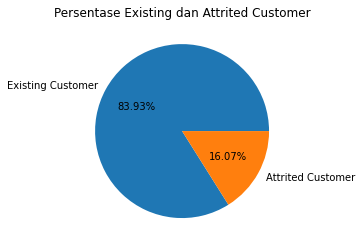

Jumlah Pelanggan Layanan Kartu Kredit:  10127 Orang
Dengan rincian: 
Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64


In [31]:
plot_pie("Attrition_Flag", title = 'Persentase Existing dan Attrited Customer')
print('Jumlah Pelanggan Layanan Kartu Kredit: ',df_all['Attrition_Flag'].count(),'Orang')
print('Dengan rincian: ')
print(df_all['Attrition_Flag'].value_counts())

Terdapat 16.07% pelanggan yang memberhentikan layanan kartu kredit dan 83.93% pelanggan yang masih menggunakan layanan kartu kredit.

### Gender

•	Gender: Demographic variable - M=Male, F=Female

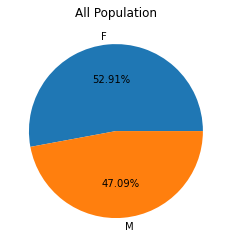

In [8]:
plot_pie('Gender',"All Population")

Dari All Customer, terdapat 52.91% dengan gender Female dan 47.09% dengan gender Male, angka ini relatif seimbang.

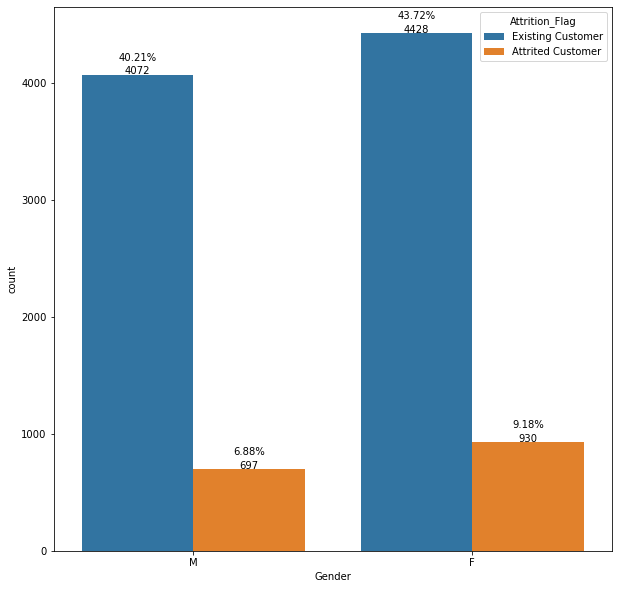

In [76]:
plt.figure(figsize=(10,10))
ax= sns.countplot(data = df_all, x='Gender', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 120,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 3,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Gender terhadap Attrition Customer.
- Untuk pelanggan yang sudah tidak menggunakkan kartu kredit, Gender Female lebih besar 2.3% dibandingkan gender Male.
- Perbandingan Rasio Gender Male untuk Attrittion dibandingkan dengan Existing sebesar 0.14.
- Perbandingan Rasio Gender Female untuk Attrittion dibandingkan dengan Existing sebesar 0.17.

## Education Level

•	Education_Level: Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.)

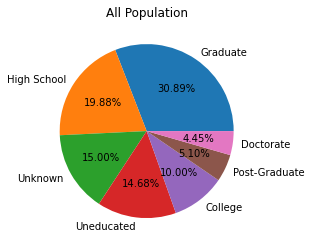

In [80]:
plot_pie('Education_Level', title="All Population")

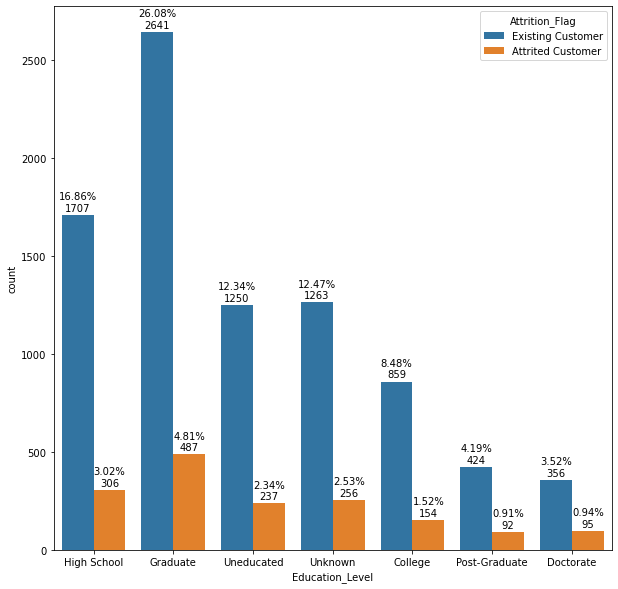

In [95]:
plt.figure(figsize=(10,10))
ax= sns.countplot(data = df_all, x='Education_Level', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 80,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 20,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Educational Level terhadap Attrition Customer.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Education level Graduate dengan persentase 4.81%.
- Perbandingan Rasio Education Unknown untuk Attrittion dibandingkan dengan Existing sebesar 0.16.
- Perbandingan Rasio Education High School untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Education Graduate untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Education Uneducated untuk Attrittion dibandingkan dengan Existing sebesar 0.15. 
- Perbandingan Rasio Education College untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Education Post-Graduate untuk Attrittion dibandingkan dengan Existing sebesar 0.17.
- Perbandingan Rasio Education Doctorate untuk Attrittion dibandingkan dengan Existing sebesar 0.21. **Tertinggi**

## Marital Status

•	Marital_Status: Demographic variable - Married, Single, Divorced, Unknown

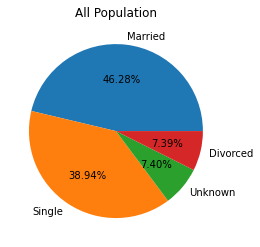

In [9]:
plot_pie('Marital_Status', title="All Population")

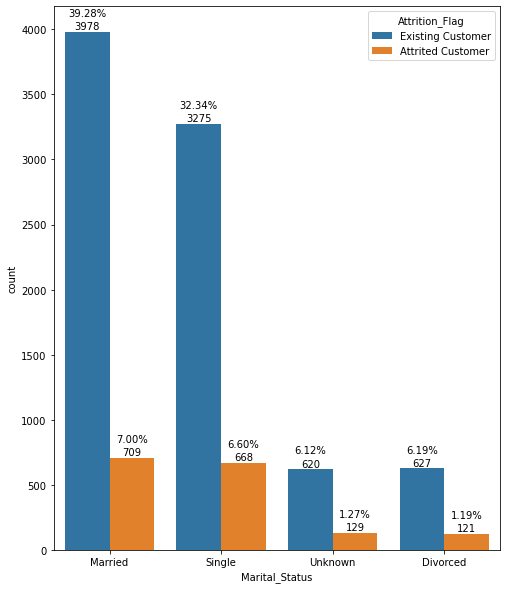

In [94]:
plt.figure(figsize=(8,10))
ax= sns.countplot(data = df_all, x='Marital_Status', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 120,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 20,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Marital Status terhadap Attrition Customer, dapat dilihat pada grafik persentase Existing lebih besar dibandingkan dengan Attration pada setiap kategori.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Married dengan persentase 7%.
- Perbandingan Rasio Marital Status Married untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Marital Status Single untuk Attrittion dibandingkan dengan Existing sebesar 0.17.
- Perbandingan Rasio Marital Status Divorced untuk Attrittion dibandingkan dengan Existing sebesar 0.16.
- Perbandingan Rasio Marital Status Unknown untuk Attrittion dibandingkan dengan Existing sebesar 0.17.

# Income Category

•	Income_Category: Demographic variable - Annual Income Category of the account holder (< 40𝐾, 40K - 60K, 60𝐾− 80K, 80𝐾− 120K,> $ 120K, Unknown)

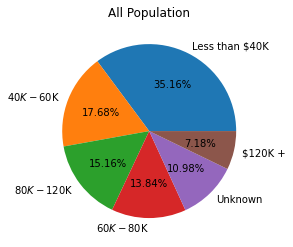

In [140]:
plot_pie('Income_Category', title="All Population")

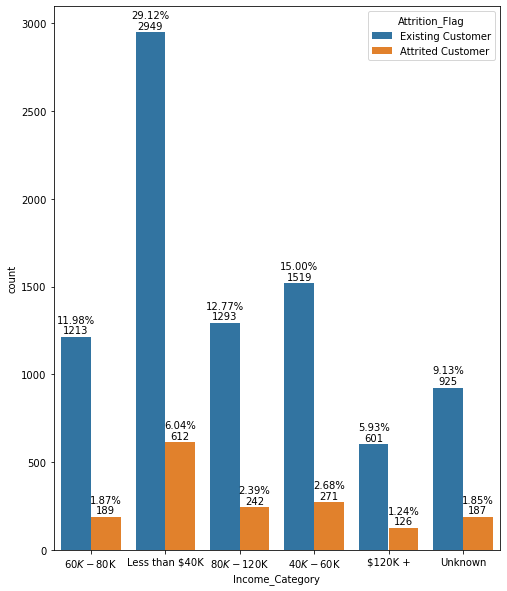

In [103]:
plt.figure(figsize=(8,10))
ax= sns.countplot(data = df_all, x='Income_Category', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 80,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center") 
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 20,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Marital Status terhadap Attrition Customer.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Less than $40k dengan persentase 6.04%.

- Perbandingan Rasio Income Category Less than $40k untuk Attrittion dibandingkan dengan Existing sebesar 0.17.
- Perbandingan Rasio Income Category 40k-60k untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Income Category 60k-80k untuk Attrittion dibandingkan dengan Existing sebesar 0.13.
- Perbandingan Rasio Income Category 80k-120k untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Income Category 120k+ untuk Attrittion dibandingkan dengan Existing sebesar 0.17.


# Card Category

•	Card_Category: Product Variable - Type of Card (Blue, Silver, Gold, Platinum)

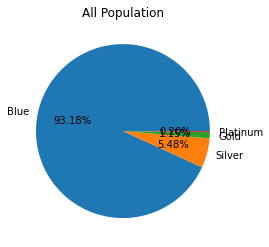

In [10]:
plot_pie('Card_Category', title="All Population")

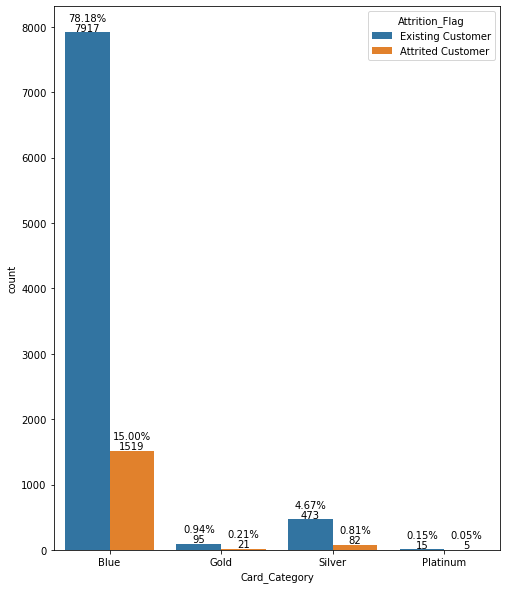

In [131]:
plt.figure(figsize=(8,10))
ax= sns.countplot(data = df_all, x='Card_Category', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 170,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 20,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Card Category terhadap Attrition Customer.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Blue Card dengan persentase 15%.
- Perbandingan Rasio Card Category Blue untuk Attrittion dibandingkan dengan Existing sebesar 0.16.
- Perbandingan Rasio Card Category Silver untuk Attrittion dibandingkan dengan Existing sebesar 0.14.
- Perbandingan Rasio Card Category Gold untuk Attrittion dibandingkan dengan Existing sebesar 0.18.
- Perbandingan Rasio Card Category Platinum untuk Attrittion dibandingkan dengan Existing sebesar 0.25.

# Customer Age

•	Customer_Age: Demographic variable - Customer's Age in Years

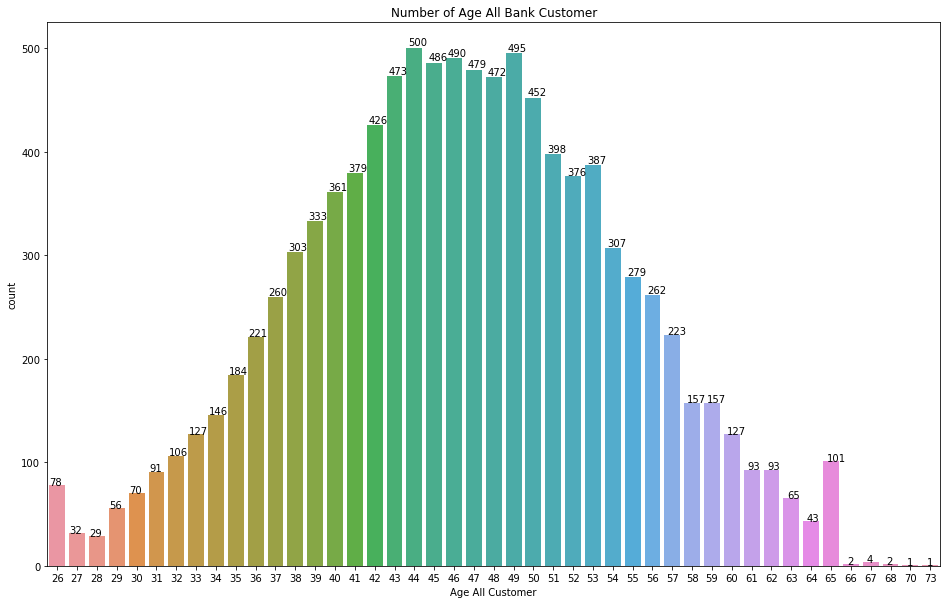

In [14]:
plt.figure(figsize = (16, 10))
plt.title('Number of Age All Bank Customer')
ax = sns.countplot(data = df_all, x = 'Customer_Age')
plt.xlabel('Age All Customer')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Customer Bank secara keseluruhan dari usia sekitar 26 - 73 tahun.
- Distribusi Customer Bank terbanyak dengan usia 42 - 50.
- Customer Bank tertinggi jumlahnya pada usia 44 tahun sebanyak 500 orang dan terendah pada usia 70 dan 73 tahun sebanyak 1 orang.

In [19]:
df_all['Customer_Age'] = df_all['Customer_Age'].round(0)

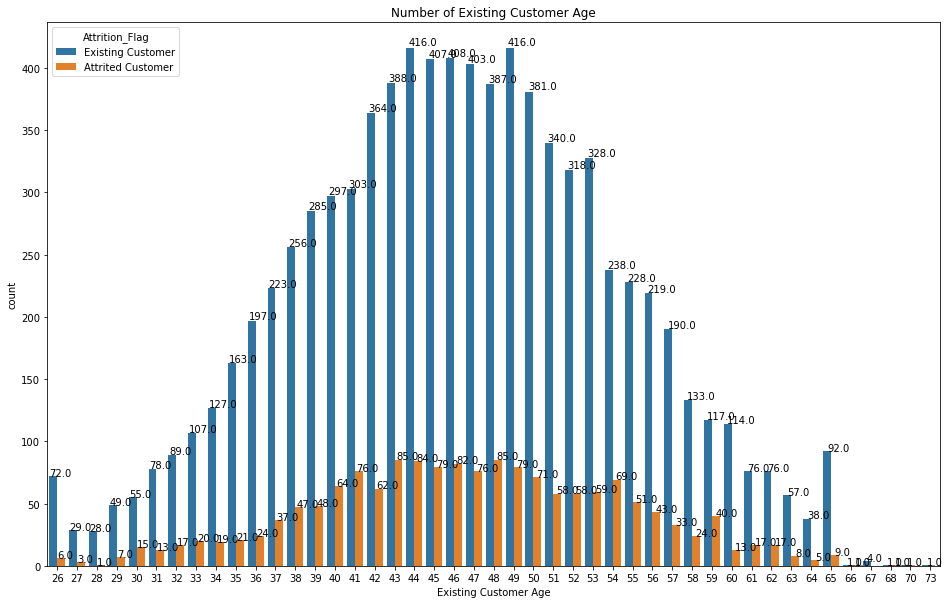

In [26]:
plt.figure(figsize = (16, 10))
plt.title('Number of Existing Customer Age')
ax = sns.countplot(data = df_all,hue = 'Attrition_Flag', x = 'Customer_Age')
plt.xlabel('Existing Customer Age')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Existing Customer secara keseluruhan dari usia 26 - 73 tahun.
- Distribusi Existing Customer terbanyak dengan usia 44 - 53.
- Existing Customer tertinggi jumlahnya pada usia 44 dan 49 tahun sebanyak 416 orang dan terendah pada usia 66, 68, 70, dan 73 tahun sebanyak 1 orang.

- Customer yang Attrited secara keseluruhan dari usia 26 - 68 tahun.
- Distribusi Customer Bank yang Attrited terbanyak dengan usia 40 - 54.
- Customer Bank yang Attrited tertinggi jumlahnya pada usia 43 dan 49 tahun sebanyak 85 orang dan terendah pada usia 28, 66, dan 68 tahun sebanyak 1 orang.

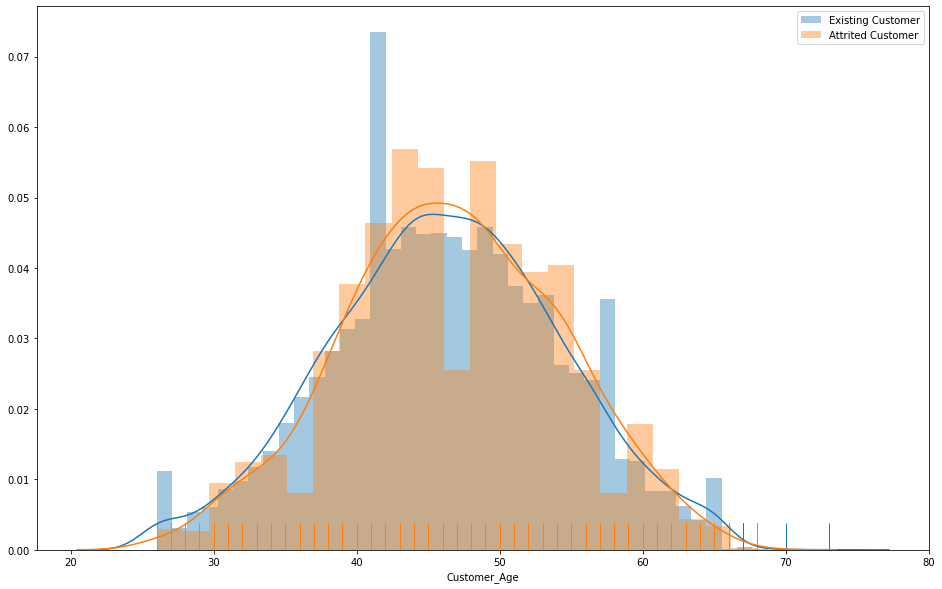

In [33]:
plt.figure(figsize=(16, 10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer']['Customer_Age'],label='Existing Customer', rug = True)
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Customer_Age'],label='Attrited Customer', rug = True)
plt.legend()

Distribusi Customer Bank yang cenderung Attrited pada range usia terbanyak dari 43 - 46 tahun dan 48 - 57 tahun. Tidak ada pengaruh signifikan.

## Dependent Counts

•	Dependent_count: Demographic variable - Number of dependents

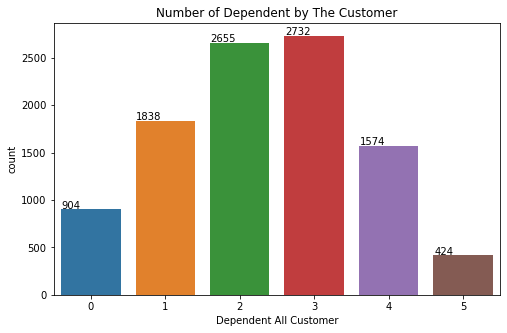

In [27]:
plt.figure(figsize = (8, 5))
plt.title('Number of Dependent by The Customer')
ax = sns.countplot(data = df_all, x = 'Dependent_count')
plt.xlabel('Dependent All Customer')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Distribusi Dependent Counts seluruh Customer Bank dari 0 -5.
- Jumlah paling tinggi pada 3 dan terendah pada 5.

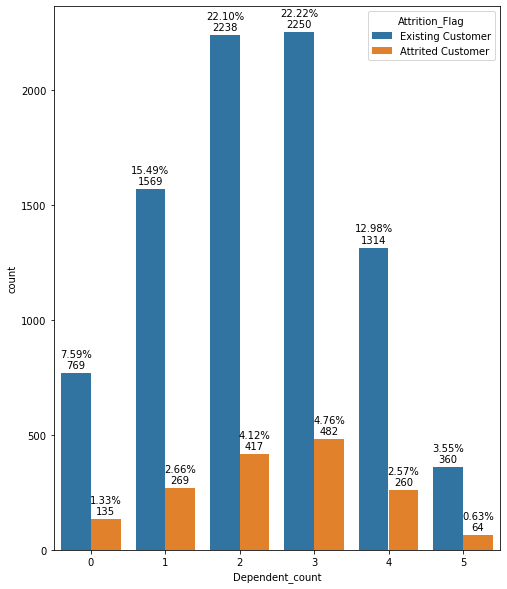

In [33]:
plt.figure(figsize=(8,10))
ax= sns.countplot(data = df_all, x='Dependent_count', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 70,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 20,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Dependent Count terhadap Attrition Customer.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Dependent Count 3 dengan persentase 4.76%.
- Perbandingan Rasio Dependent Count 0 untuk Attrittion dibandingkan dengan Existing sebesar 0.14.
- Perbandingan Rasio Dependent Count 1 untuk Attrittion dibandingkan dengan Existing sebesar 0.14.
- Perbandingan Rasio Dependent Count 2 untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Dependent Count 3 untuk Attrittion dibandingkan dengan Existing sebesar 0.17.
- Perbandingan Rasio Dependent Count 4 untuk Attrittion dibandingkan dengan Existing sebesar 0.16.
- Perbandingan Rasio Dependent Count 5 untuk Attrittion dibandingkan dengan Existing sebesar 0.15.

# Month on Book

Period of relationship with bank

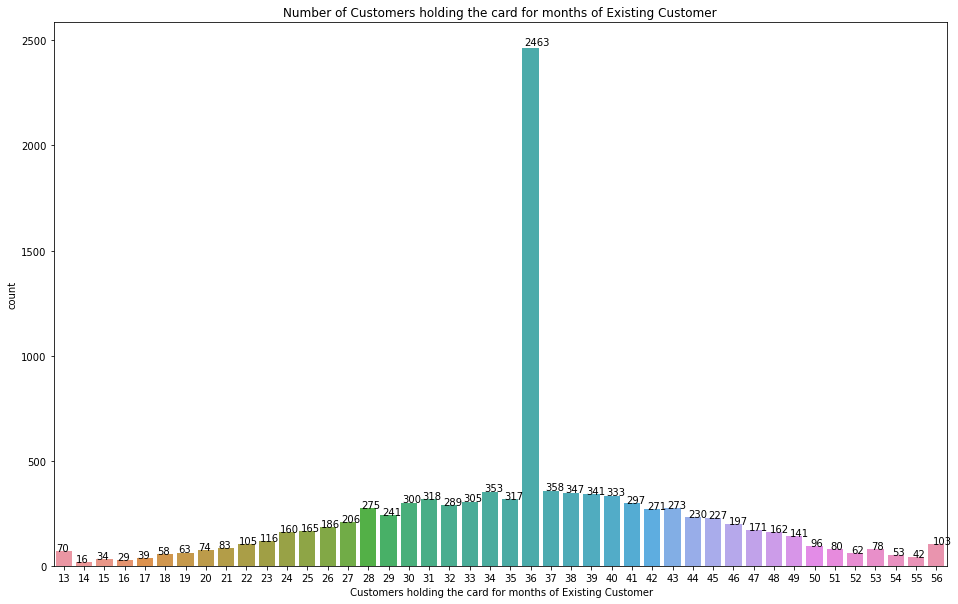

In [40]:
plt.figure(figsize = (16, 10))
plt.title('Number of Customers holding the card for months of Existing Customer')
ax = sns.countplot(data = df_all, x = 'Months_on_book')
plt.xlabel(' Customers holding the card for months of Existing Customer')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Customer terbanyak menggunakan pada penggunaan 36 bulan.
- Customer dengan penggunaan paling rendah yaitu 13 bulan sebanyak 70 orang.
- Customer dengan penggunaan paling lama yaitu 56 bulan sebanyak 103 orang.

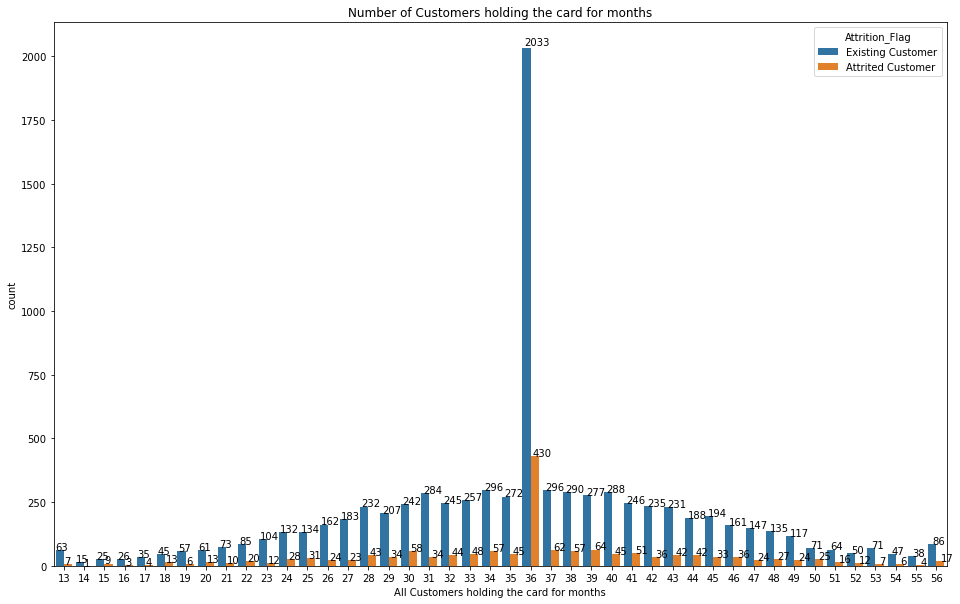

In [142]:
plt.figure(figsize = (16, 10))
plt.title('Number of Customers holding the card for months')
ax = sns.countplot(data = df_all, x = 'Months_on_book', hue = 'Attrition_Flag')
plt.xlabel('All Customers holding the card for months')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Existing Customer terbanyak menggunakan pada penggunaan 36 bulan.
- Existing Customer dengan penggunaan paling rendah yaitu 13 bulan sebanyak 63 orang.
- Existing Customer dengan penggunaan paling lama yaitu 56 bulan sebanyak 86 orang.

- Attrited Customer terbanyak menggunakan pada penggunaan 36 bulan.
- AttritedAttrited Customer dengan penggunaan paling rendah yaitu 13 bulan sebanyak 7 orang.
- Attrited Customer dengan penggunaan paling lama yaitu 56 bulan sebanyak 17 orang.

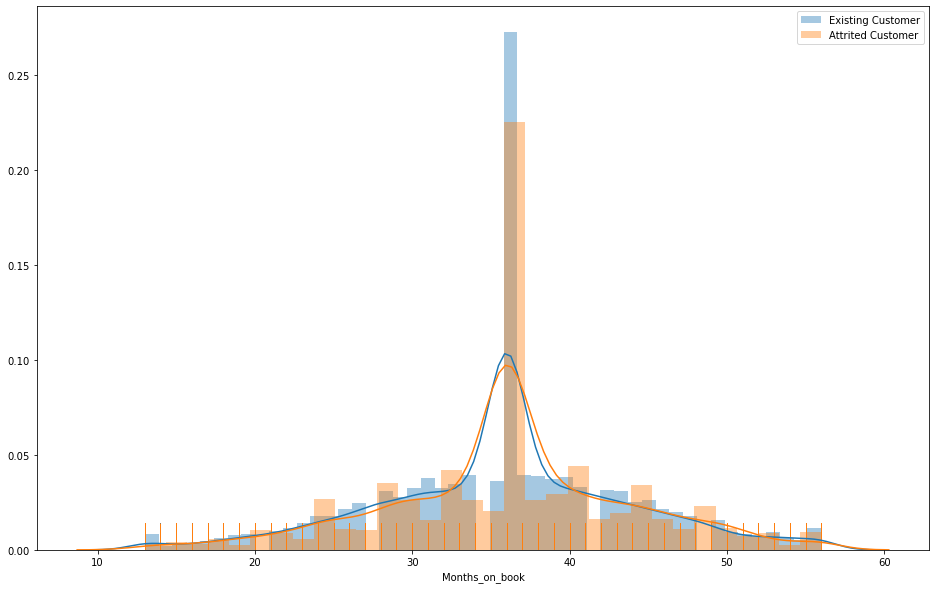

In [10]:
plt.figure(figsize=(16, 10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer']['Months_on_book'],label='Existing Customer', rug = True)
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Months_on_book'],label='Attrited Customer', rug = True)
plt.legend()

Tidak ada pengaruh signifikan dari Customer Age terhadap Attrition Customer.

# Total Relationship Count

Total number of products held by the customer.

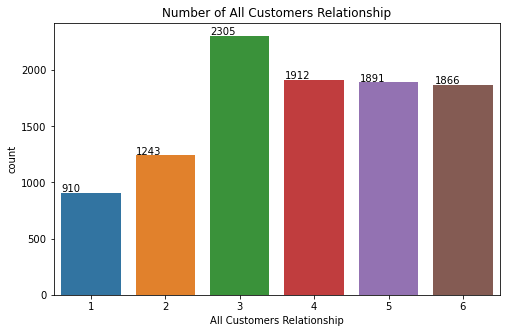

In [46]:
plt.figure(figsize = (8, 5))
plt.title('Number of All Customers Relationship')
ax = sns.countplot(data = df_all, x = 'Total_Relationship_Count')
plt.xlabel('All Customers Relationship')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

- Customer tertinggi menggunakan produk berjumlah 3. Pada jumlah 4, 5, dan 6 memiliki jumlah yang relatif jumlahnya tidak jauh beda.
- Customer terendah menggunakan produk sebanyak 1.

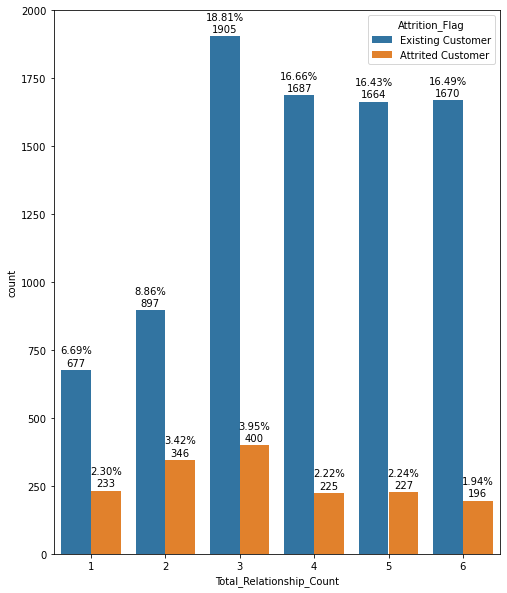

In [43]:
plt.figure(figsize=(8,10))
ax= sns.countplot(data = df_all, x='Total_Relationship_Count', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 60,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 15,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Total Relationship Count terhadap Attrition Customer.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Total Relationship Count 3 dengan persentase 3.95%.
- Perbandingan Rasio Total Relationship Count 1 untuk Attrittion dibandingkan dengan Existing sebesar 0.25.
- Perbandingan Rasio Total Relationship Count 2 untuk Attrittion dibandingkan dengan Existing sebesar 0.27.
- Perbandingan Rasio Total Relationship Count 3 untuk Attrittion dibandingkan dengan Existing sebesar 0.17.
- Perbandingan Rasio Total Relationship Count 4 untuk Attrittion dibandingkan dengan Existing sebesar 0.11.
- Perbandingan Rasio Total Relationship Count 5 untuk Attrittion dibandingkan dengan Existing sebesar 0.12.
- Perbandingan Rasio Total Relationship Count 6 untuk Attrittion dibandingkan dengan Existing sebesar 0.10.

# Months_Inactive_12_mon

No. of months inactive in the last 12 months

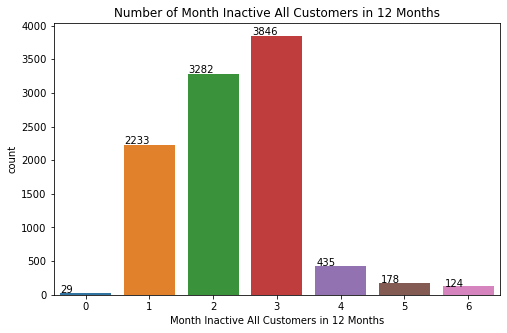

In [9]:
plt.figure(figsize = (8, 5))
plt.title('Number of Month Inactive All Customers in 12 Months')
ax = sns.countplot(data = df_all, x = 'Months_Inactive_12_mon')
plt.xlabel('Month Inactive All Customers in 12 Months')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Customer tertinggi jumlah bulan tidak aktif adalah 3 dalam 12 bulan terakhir.

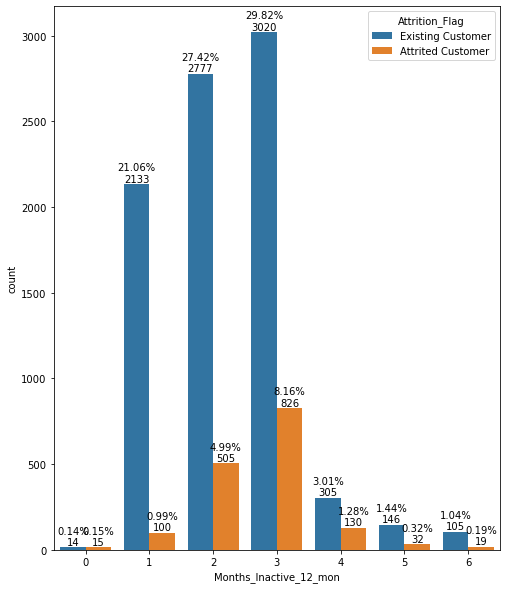

In [265]:
plt.figure(figsize=(8,10))
ax= sns.countplot(data = df_all, x='Months_Inactive_12_mon', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 80,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 15,
                        str(p.get_height()),
                        ha="center")

- Tidak ada pengaruh signifikan dari Months Inactive 12 Months terhadap Attrition Customer.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Months Inactive 12 Month pada 3 Month dengan persentase 8.16%.
- Perbandingan Rasio Months Inactive 12 Month pada 0 Month untuk Attrittion dibandingkan dengan Existing sebesar 0.51.
- Perbandingan Rasio Months Inactive 12 Month pada 1 Month untuk Attrittion dibandingkan dengan Existing sebesar 0.04.
- Perbandingan Rasio Months Inactive 12 Month pada 2 Month untuk Attrittion dibandingkan dengan Existing sebesar 0.15.
- Perbandingan Rasio Months Inactive 12 Month pada 3 Month untuk Attrittion dibandingkan dengan Existing sebesar 0.21.
- Perbandingan Rasio Months Inactive 12 Month pada 4 Month untuk Attrittion dibandingkan dengan Existing sebesar 0.29.
- Perbandingan Rasio Months Inactive 12 Month pada 5 Month untuk Attrittion dibandingkan dengan Existing sebesar 0.18.
- Perbandingan Rasio Months Inactive 12 Month pada 6 Month untuk Attrittion dibandingkan dengan Existing sebesar 0.15.


# Contacts_Count_12_mon

No. of Contacts in the last 12 months

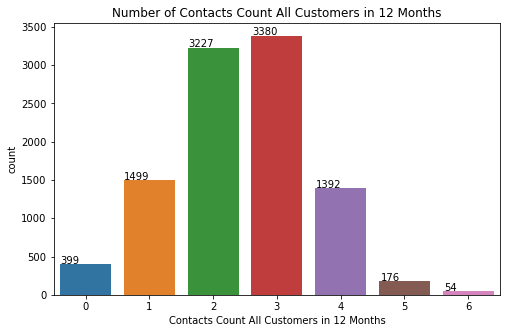

In [61]:
plt.figure(figsize = (8, 5))
plt.title('Number of Contacts Count All Customers in 12 Months')
ax = sns.countplot(data = df_all, x = 'Contacts_Count_12_mon')
plt.xlabel('Contacts Count All Customers in 12 Months')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

Customer tertinggi jumlah kontak adalah 3 dalam 12 bulan terakhir.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


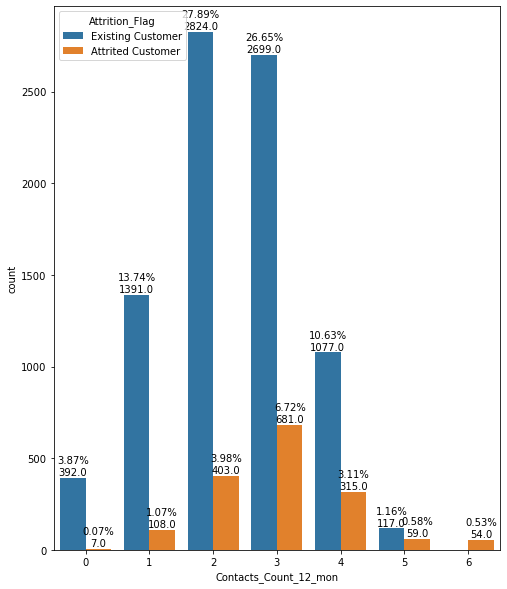

In [275]:
plt.figure(figsize=(8,10))
ax= sns.countplot(data = df_all, x='Contacts_Count_12_mon', hue = 'Attrition_Flag')
for p in ax.patches:
                height = p.get_height()
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 80,
                        '{:1.2f}%'.format(height/len(df_all)*100),
                        ha="center")
                ax.text(p.get_x()+p.get_width()/2.,
                        height + 15,
                        str(p.get_height()),
                        ha="center")

In [284]:
59/(59+117)

0.3352272727272727

- Tidak ada pengaruh signifikan dari Months Inactive 12 Months terhadap Attrition Customer.
- Pelanggan kartu kredit dengan jumlah Attrition tertinggi pada Contacts Count 12 Month pada 3 dengan persentase 6.72%.
- Perbandingan Rasio Contacts Count 12 Months pada jumlah 0 untuk Attrittion dibandingkan dengan Existing sebesar 0.17.
- Perbandingan Rasio Contacts Count 12 Months pada jumlah 1 untuk Attrittion dibandingkan dengan Existing sebesar 0.07.
- Perbandingan Rasio Contacts Count 12 Months pada jumlah 2 untuk Attrittion dibandingkan dengan Existing sebesar 0.12.
- Perbandingan Rasio Contacts Count 12 Months pada jumlah 3 untuk Attrittion dibandingkan dengan Existing sebesar 0.20.
- Perbandingan Rasio Contacts Count 12 Months pada jumlah 4 untuk Attrittion dibandingkan dengan Existing sebesar 0.22.
- Perbandingan Rasio Contacts Count 12 Months pada jumlah 5 untuk Attrittion dibandingkan dengan Existing sebesar 0.33.
- Perbandingan Rasio Contacts Count 12 Months pada jumlah 6 untuk Attrittion dibandingkan dengan Existing sebesar 1.


# Credit_Limit

Credit Limit on the Credit Card

Text(0.5, 0, 'Credit Limit All Customers')

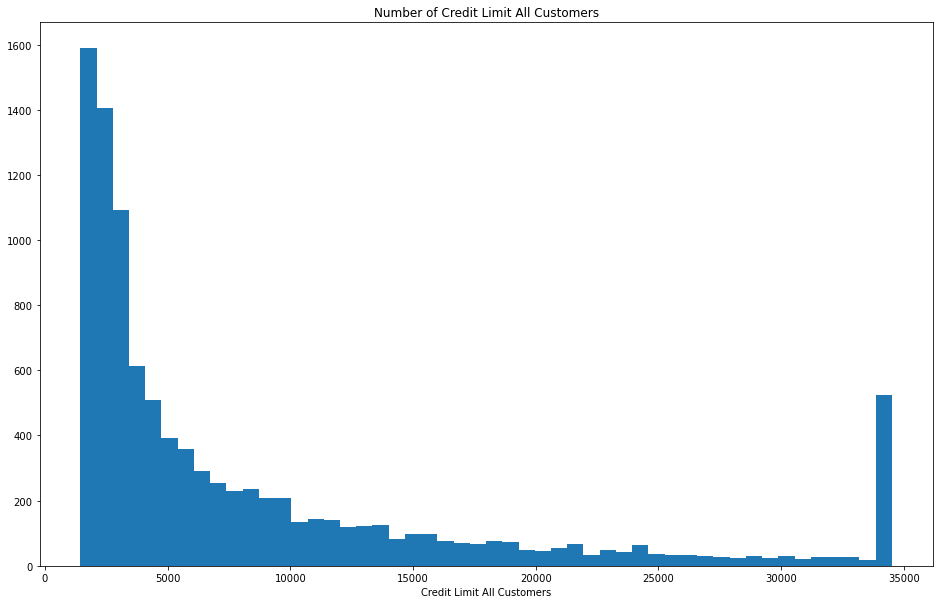

In [104]:
plt.figure(figsize = (16, 10))
plt.title('Number of Credit Limit All Customers')
ax = plt.hist(df_all['Credit_Limit'], bins=50, density = False)
plt.xlabel('Credit Limit All Customers')

Jumlah customer tertinggi dengan limit kredit sekitar 1000, lalu jumlahnya signifikan menurun sampai dengan limit sekitar 33000. Lalu mengalami kenaikan jumlah cukup pesat pada limit kredit 33000 - 33500.

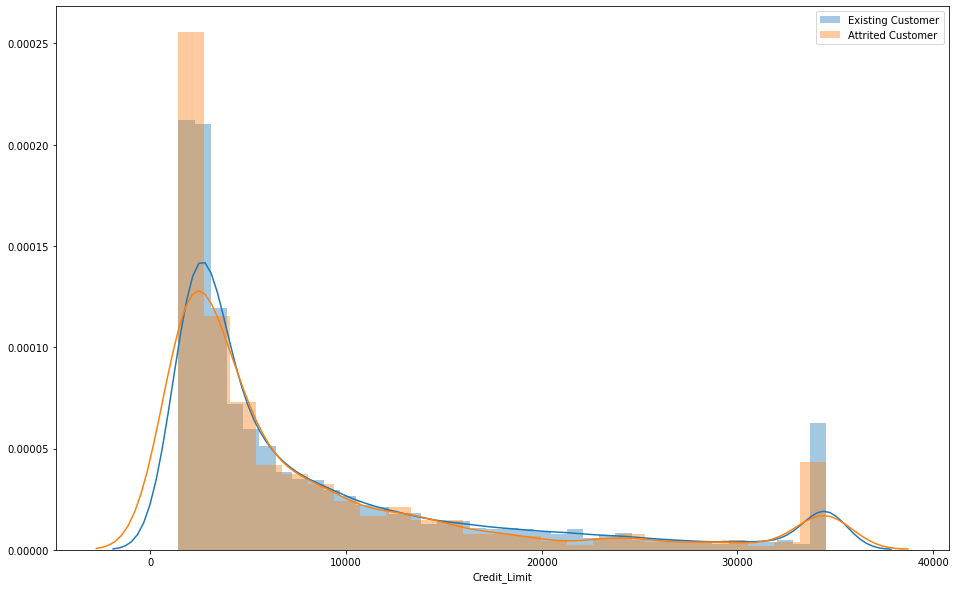

In [19]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer']['Credit_Limit'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Credit_Limit'],label='Attrited Customer')
plt.legend()

- Terdapat kecenderungan Attrited Customer dengan jumlah limit kredit pada sekitar kurang dari 1500.
- Tidak ada pengaruh signifikan Credit Limit terhadap Attririon Customer.

# Total_Revolving_Bal

Total Revolving Balance on the Credit Card

Text(0.5, 0, 'Total_Revolving_Bal All Customers')

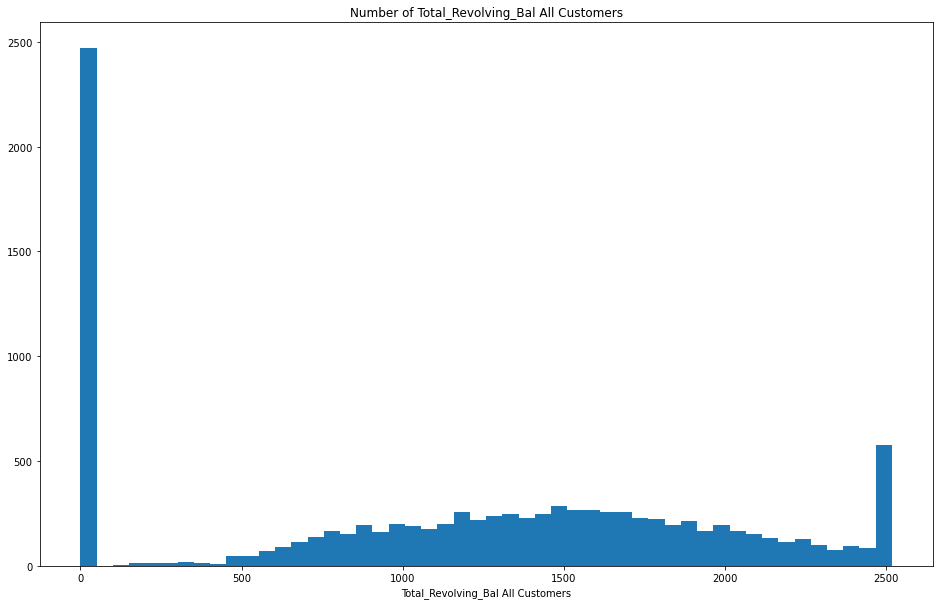

In [28]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Revolving_Bal All Customers')
ax = plt.hist(df_all['Total_Revolving_Bal'], bins=50, density = False)
plt.xlabel('Total_Revolving_Bal All Customers')

Jumlah Customer tertinggi Revolving balance pada range 0-100.

Text(0.5, 0, 'Total_Revolving_Bal Existing Customers')

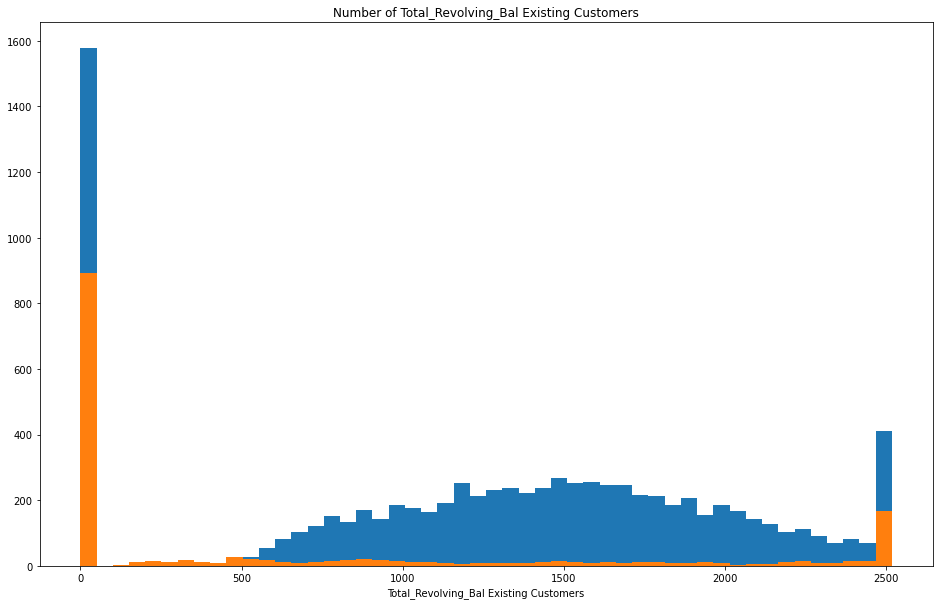

In [29]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Revolving_Bal Existing Customers')
plt.hist(df_nonchurned['Total_Revolving_Bal'], bins=50, density = False)
plt.hist(df_churned['Total_Revolving_Bal'], bins=50, density = False)
plt.xlabel('Total_Revolving_Bal Existing Customers')

- Existing Customer dan Attrited Customer jumlah tertinggi pada range 0-100.

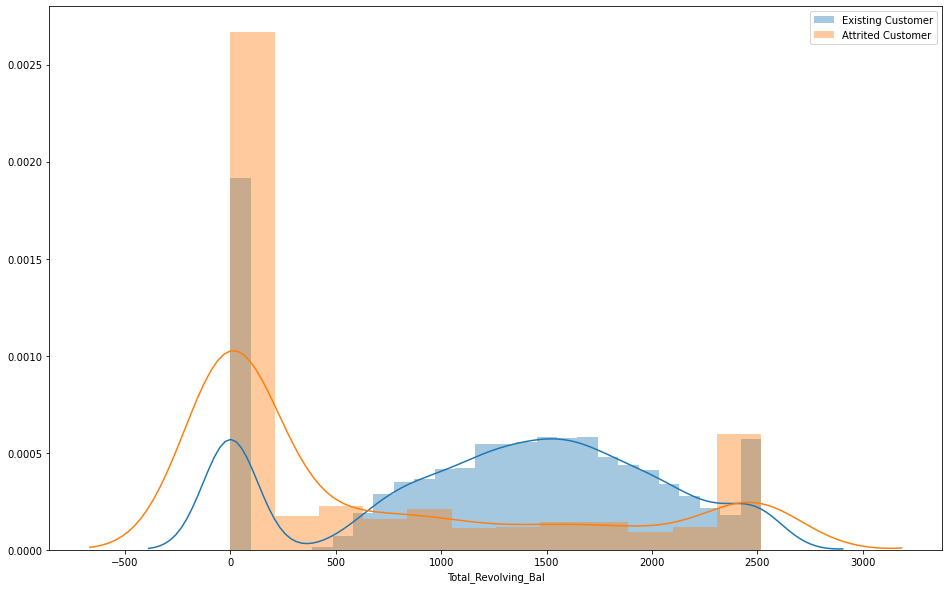

In [111]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer'][ 'Total_Revolving_Bal'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Total_Revolving_Bal'],label='Attrited Customer')
plt.legend()

Terdapat kecenderungan Attrited Customer dengan jumlah revolving balance pada range 0 - 500.

# Avg_Open_To_Buy

Open to Buy Credit Line (Average of last 12 months)

Text(0.5, 0, 'Avg_Open_To_Buy All Customers')

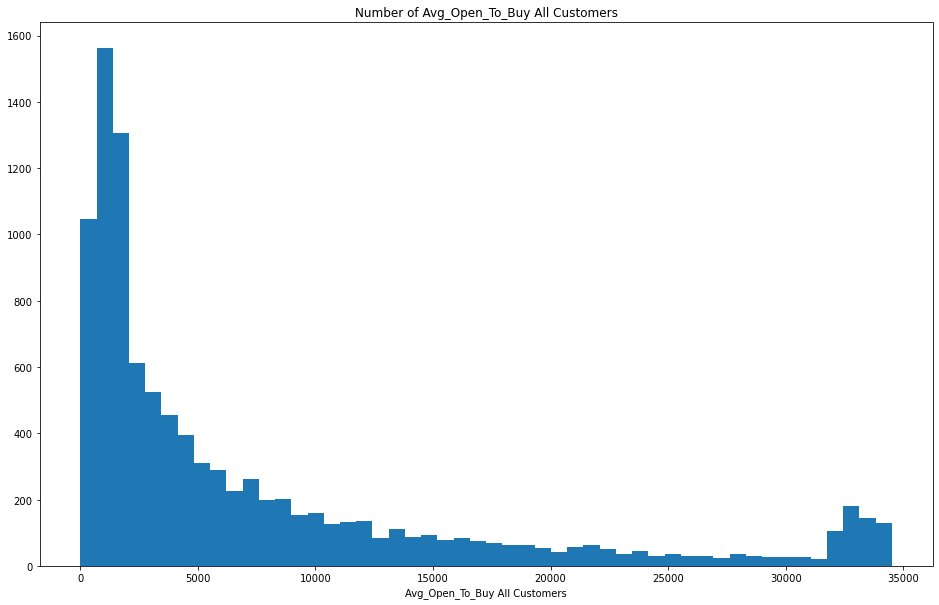

In [112]:
plt.figure(figsize = (16, 10))
plt.title('Number of Avg_Open_To_Buy All Customers')
ax = plt.hist(df_all['Avg_Open_To_Buy'], bins=50, density = False)
plt.xlabel('Avg_Open_To_Buy All Customers')

Jumlah Customer Open to Buy dalam rentan waktu 12 bulan terdapat kenaikan pada range 0-2500. Lalu ada penurunan secara signifikan sampai range 32000, setelah itu ada kenaikan kembali sampai range 34500.

Text(0.5, 0, 'Avg_Open_To_Buy Existing Customers')

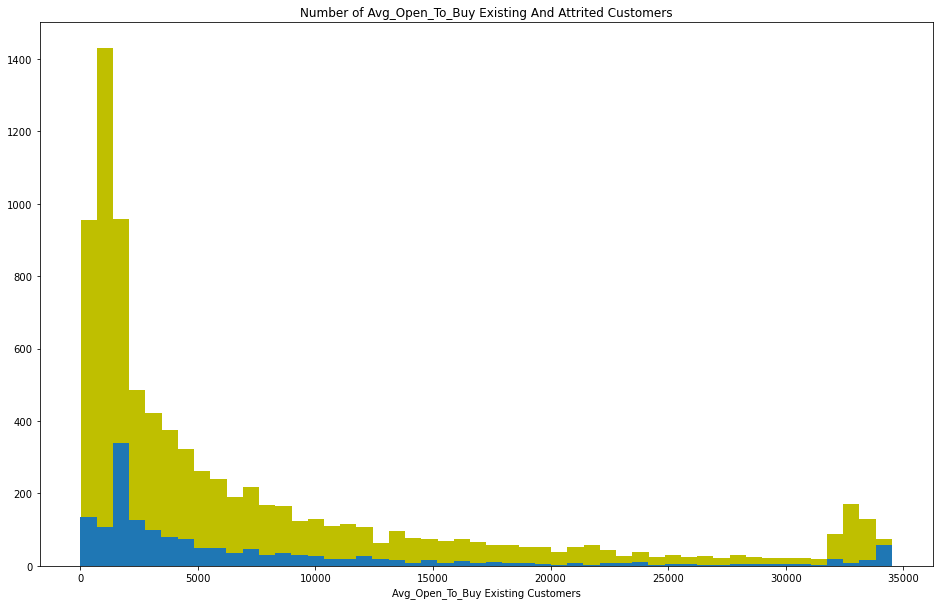

In [26]:
plt.figure(figsize = (16, 10))
plt.title('Number of Avg_Open_To_Buy Existing And Attrited Customers')
plt.hist(df_nonchurned['Avg_Open_To_Buy'], bins=50, density = False, color='y')
plt.hist(df_churned['Avg_Open_To_Buy'], bins=50, density = False)
plt.xlabel('Avg_Open_To_Buy Existing Customers')

- Existing Customer distribusinya tidak berbeda dengan All Customer.
- Attrited Customer kenaikan pada range 0-3500. Lalu ada penurunan secara signifikan sampai range 32000, setelah itu ada kenaikan kembali sampai range 34500.
- Jumlah Existing Customer lebih banyak dibandingkan Attrited Customer.

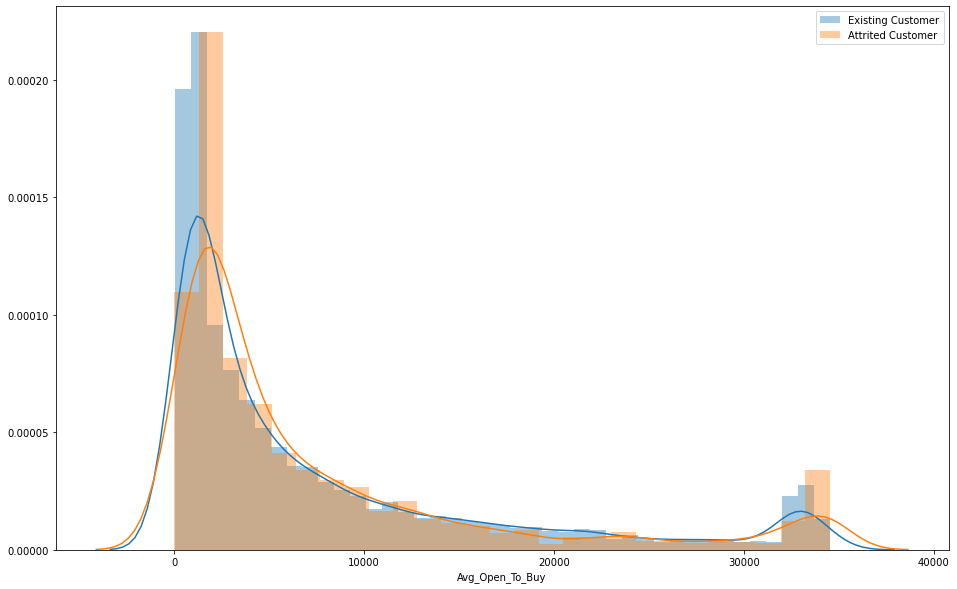

In [115]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer'][ 'Avg_Open_To_Buy'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Avg_Open_To_Buy'],label='Attrited Customer')
plt.legend()

Tidak ada pengaruh signifikan Avg Open to Buy dengan Attrition Customer.

# Total_Amt_Chng_Q4_Q1

Change in Transaction Amount (Q4 over Q1)

In [13]:
df_all['Total_Amt_Chng_Q4_Q1'].min()

0.0

Text(0.5, 0, 'Total_Amt_Chng_Q4_Q1 All Customers')

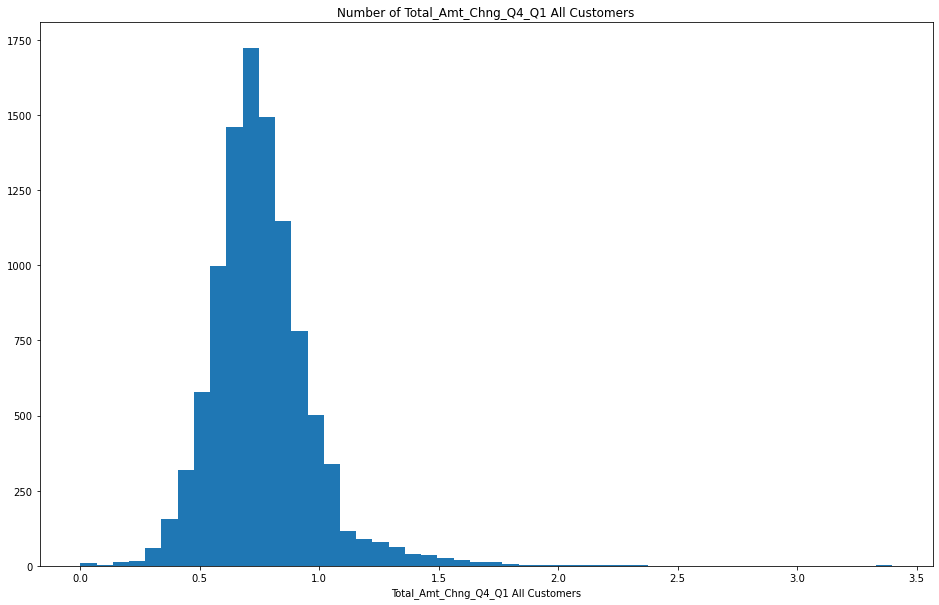

In [116]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Amt_Chng_Q4_Q1 All Customers')
ax = plt.hist(df_all['Total_Amt_Chng_Q4_Q1'], bins=50, density = False)
plt.xlabel('Total_Amt_Chng_Q4_Q1 All Customers')

jumlah tertinggi Customer dengan Change in Transaction Q4 over Q1 pada peresentase 0-0.75%, lalu ada terjadi penurunan jumlah dari persentasenya. Namun tidak ada persentase minus, artinya tidak ada penurunan transaksi tiap tahunnya.

Text(0.5, 0, 'Total_Amt_Chng_Q4_Q1 Existing and Attrited Customers')

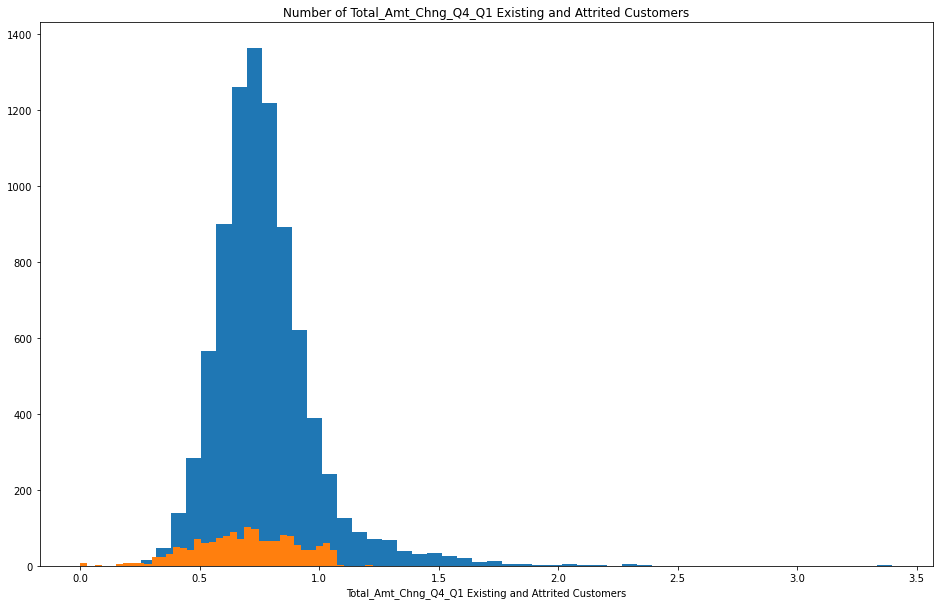

In [17]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Amt_Chng_Q4_Q1 Existing and Attrited Customers')
plt.hist(df_nonchurned['Total_Amt_Chng_Q4_Q1'], bins=50, density = False)
plt.hist(df_churned['Total_Amt_Chng_Q4_Q1'], bins=50, density = False)
plt.xlabel('Total_Amt_Chng_Q4_Q1 Existing and Attrited Customers')

Distribusi dari Existing dan Attrited tidak ada perbedaan signifikan dengan distribusi jumlah All Customers.

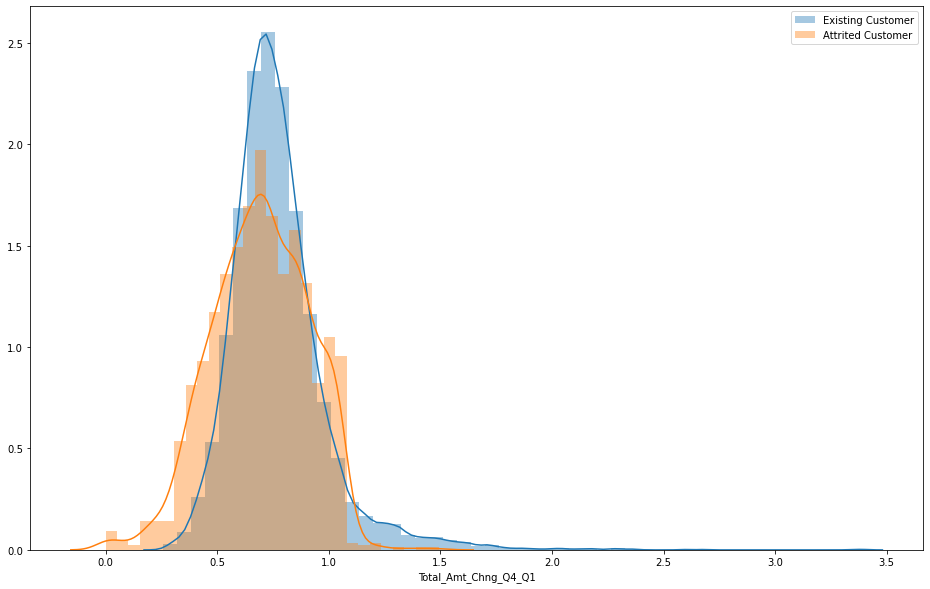

In [119]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer'][ 'Total_Amt_Chng_Q4_Q1'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Total_Amt_Chng_Q4_Q1'],label='Attrited Customer')
plt.legend()

Terdapat pengaruh dari Change in Transaction Amount (Q4 over Q1) pada persentase 0 - 0.5% dan 1 - 1,2%.

# Total_Trans_Amt

Total Transaction Amount (Last 12 months)

Text(0.5, 0, 'Total_Trans_Amt All Customers')

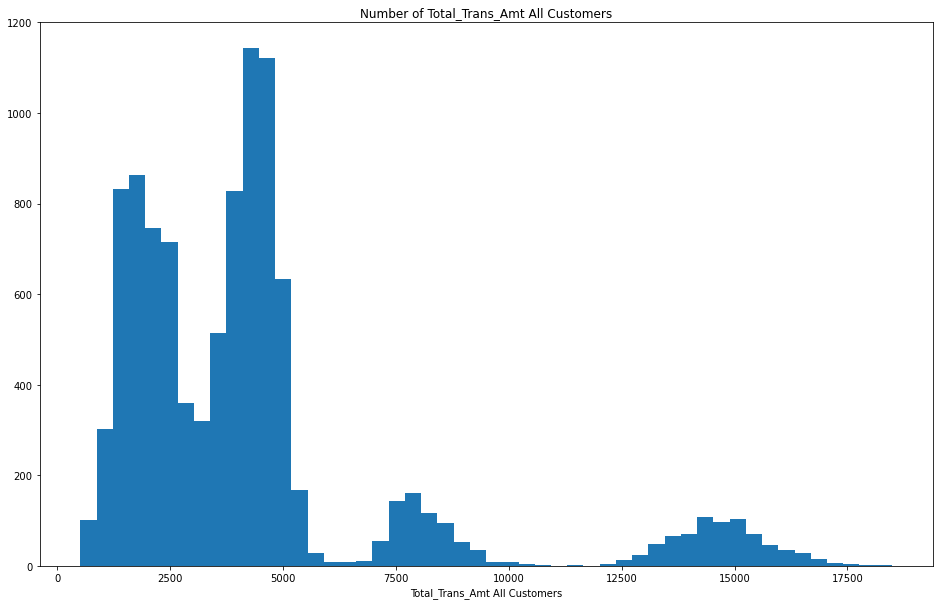

In [100]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Trans_Amt All Customers')
ax = plt.hist(df_all['Total_Trans_Amt'], bins=50, density = False)
plt.xlabel('Total_Trans_Amt All Customers')

Distribusi jumlah transaksi tertinggi pada range 4000 - 4500.

Text(0.5, 0, 'Total_Trans_Amt Existing Customers')

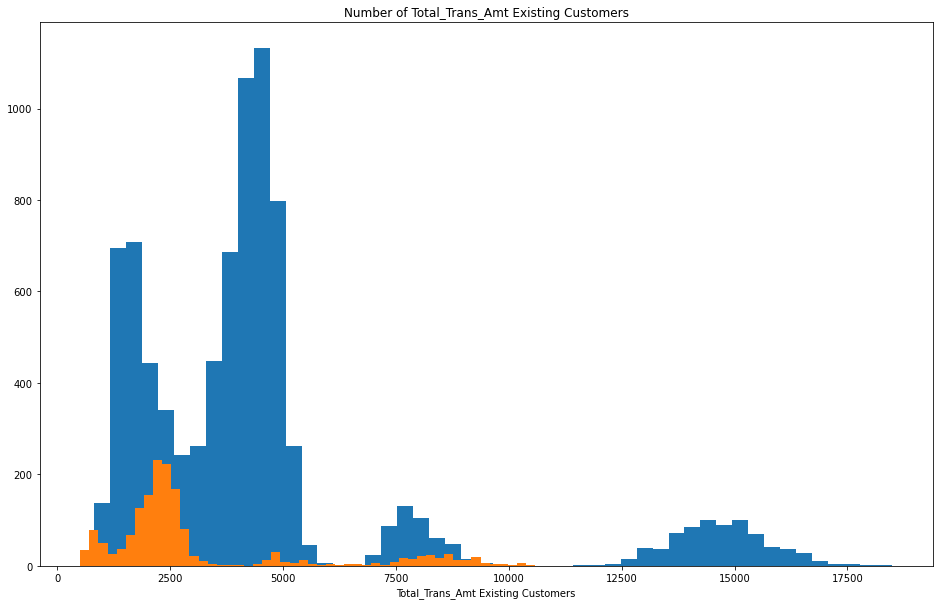

In [52]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Trans_Amt Existing Customers')
plt.hist(df_nonchurned['Total_Trans_Amt'], bins=50, density = False)
plt.hist(df_churned['Total_Trans_Amt'], bins=50, density = False)
plt.xlabel('Total_Trans_Amt Existing Customers')

- Distribusi jumlah transaksi pada Existing Customer dengan All Customer tidak jauh berbeda.
- Distribusi jumlah transaksi pada Attrited Customer tertinggi pada jumlah 2000 - 2500.

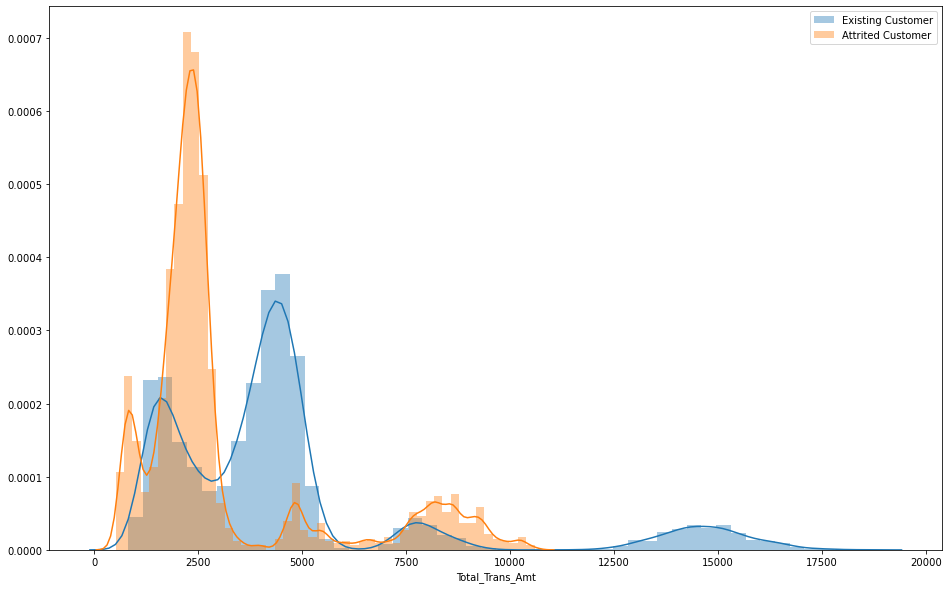

In [66]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer'][ 'Total_Trans_Amt'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Total_Trans_Amt'],label='Attrited Customer')
plt.legend()

- Terdapat kecenderungan Attrited Customer pada total jumlah transaksi kurang dari 2500 dan pada range 7500 - 10500. Namun tertinggi pada kurang dari 2500.

# Total_Trans_Ct

Total Transaction Count (Last 12 months)

Text(0.5, 0, 'Total_Trans_Ct All Customers')

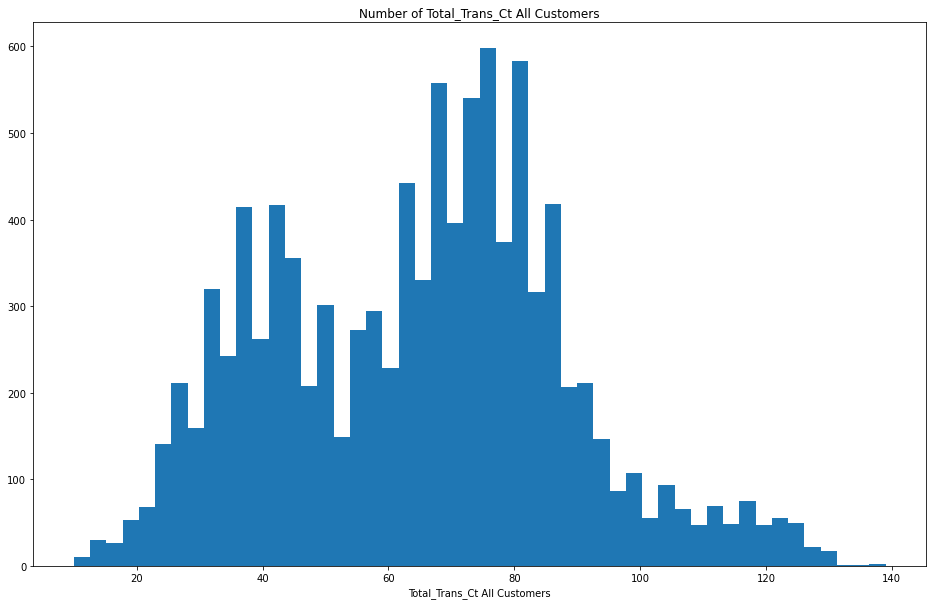

In [61]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Trans_Ct All Customers')
ax = plt.hist(df_all['Total_Trans_Ct'],bins=50, density = False)
plt.xlabel('Total_Trans_Ct All Customers')

Total transaksi All Customer tertinggi rata-rata pada 60-80 kali.

Text(0.5, 0, 'Total_Trans_Ct Customers')

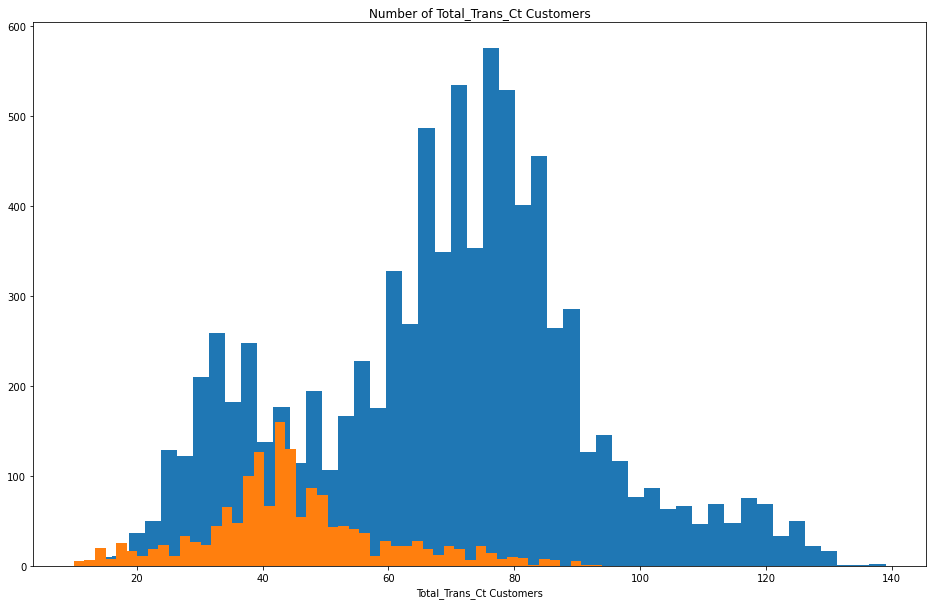

In [329]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Trans_Ct Customers')
plt.hist(df_nonchurned['Total_Trans_Ct'], bins=50, density = False)
plt.hist(df_churned['Total_Trans_Ct'], bins=50, density = False)
plt.xlabel('Total_Trans_Ct Customers')

- Distribusi jumlah transaksi pada Existing Customer dengan All Customer tidak jauh berbeda.
- Distribusi jumlah transaksi pada Attrited Customer tertinggi pada range 35 - 45.

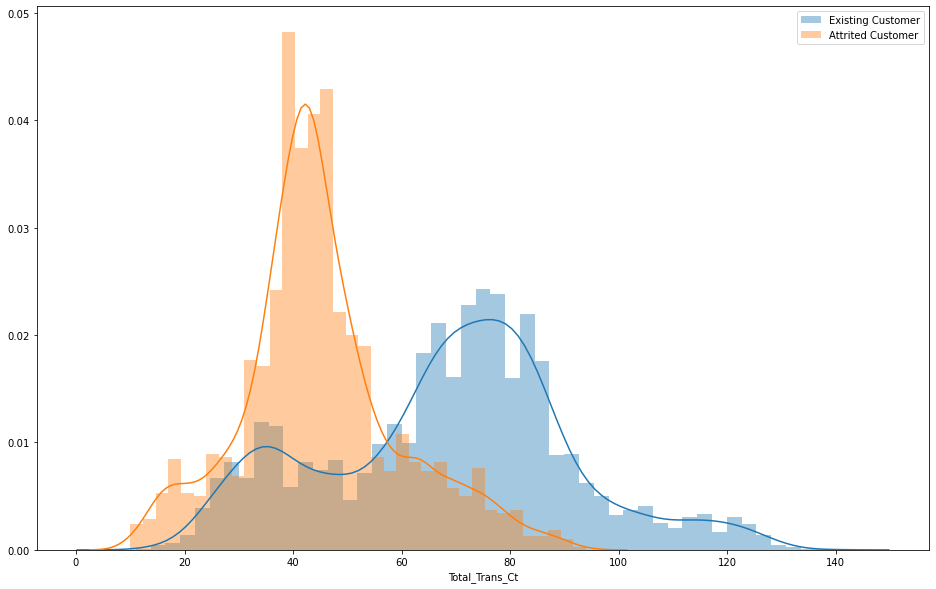

In [123]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer']['Total_Trans_Ct'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Total_Trans_Ct'],label='Attrited Customer')
plt.legend()

Terdapat kecenderungan Attrited Customer pada total transaksi kurang dari 55.

# Total_Ct_Chng_Q4_Q1

Change in Transaction Count (Q4 over Q1)

Text(0.5, 0, 'Total_Ct_Chng_Q4_Q1 All Customers')

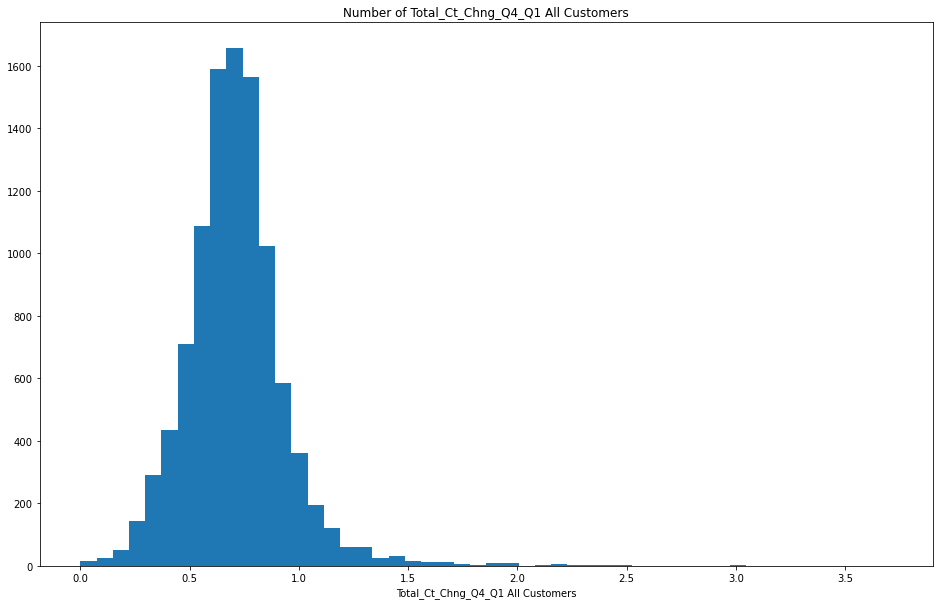

In [124]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Ct_Chng_Q4_Q1 All Customers')
ax = plt.hist(df_all['Total_Ct_Chng_Q4_Q1'], bins=50, density = False)
plt.xlabel('Total_Ct_Chng_Q4_Q1 All Customers')

jumlah tertinggi Customer dengan Change in Transaction Count Q4 over Q1 pada peresentase 0-0.75%, lalu ada terjadi penurunan jumlah dari persentasenya. Namun tidak ada persentase minus, artinya tidak ada penurunan transaksi tiap tahunnya.

Text(0, 0.5, 'Count')

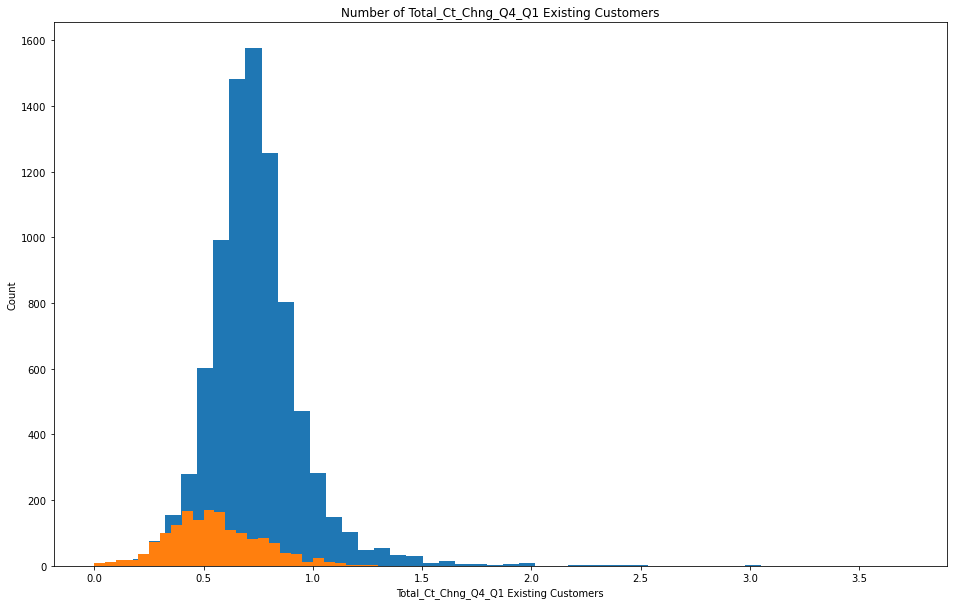

In [65]:
plt.figure(figsize = (16, 10))
plt.title('Number of Total_Ct_Chng_Q4_Q1 Existing Customers')
plt.hist(df_nonchurned['Total_Ct_Chng_Q4_Q1'], bins=50, density = False)
plt.hist(df_churned['Total_Ct_Chng_Q4_Q1'], bins=50, density = False)
plt.xlabel('Total_Ct_Chng_Q4_Q1 Existing Customers')
plt.ylabel('Count')

Distribusi persentase  Change in Transaction Count pada Existing Customer dengan All Customer tidak jauh berbeda.
Distribusi persentase  Change in Transaction Count pada Attrited Customer tertinggi pada range 0.4 - 0.6.

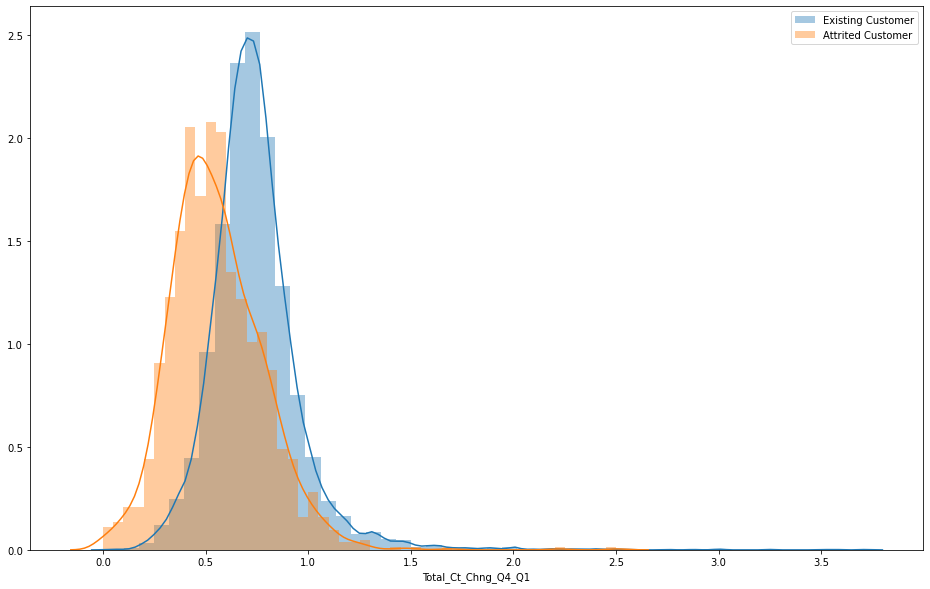

In [67]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer']['Total_Ct_Chng_Q4_Q1'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Total_Ct_Chng_Q4_Q1'],label='Attrited Customer')
plt.legend()

Terdapat kecenderungan Attrited Customer pada persentase Change in Transaction Count kurang dari 0.5.

# Avg_Utilization_Ratio

Average Card Utilization Ratio

Text(0, 0.5, 'Count')

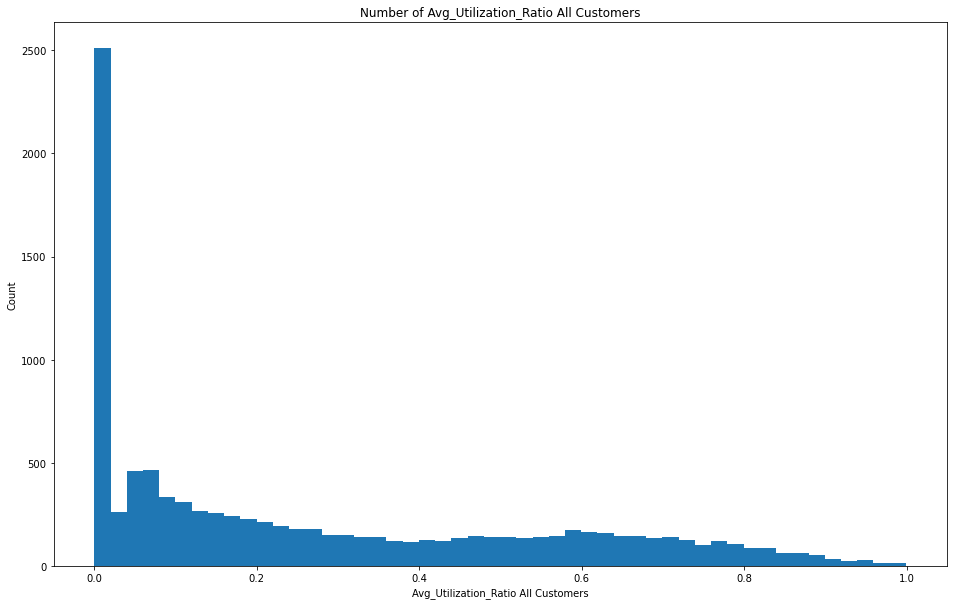

In [129]:
plt.figure(figsize = (16, 10))
plt.title('Number of Avg_Utilization_Ratio All Customers')
ax = plt.hist(df_all['Avg_Utilization_Ratio'], bins=50, density = False)
plt.xlabel('Avg_Utilization_Ratio All Customers')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

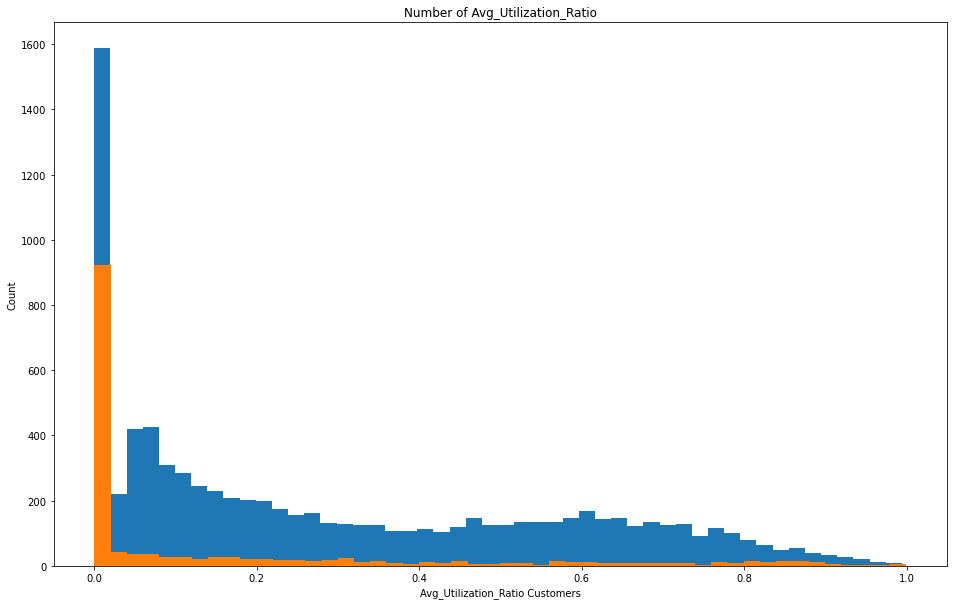

In [288]:
plt.figure(figsize = (16, 10))
plt.title('Number of Avg_Utilization_Ratio')
plt.hist(df_nonchurned['Avg_Utilization_Ratio'], bins=50, density = False)
plt.hist(df_churned['Avg_Utilization_Ratio'], bins=50, density = False)
plt.xlabel('Avg_Utilization_Ratio Customers')
plt.ylabel('Count')

Jumlah dari Existing Customer pada feature Avg_Utilization_Ratio lebih tinggi dibandingkan Attrited Customer.

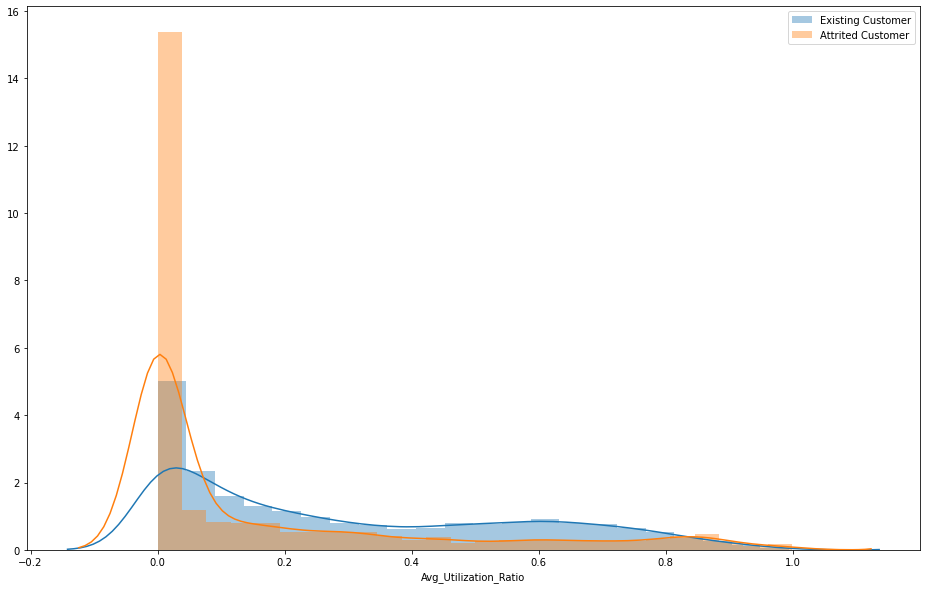

In [285]:
plt.figure(figsize=(16,10))
sns.distplot(df_all[df_all['Attrition_Flag']=='Existing Customer']['Avg_Utilization_Ratio'],label='Existing Customer')
sns.distplot(df_all[df_all['Attrition_Flag']=='Attrited Customer']['Avg_Utilization_Ratio'],label='Attrited Customer')
plt.legend()

In [ ]:
Average Card Utilization Ratio 0.1 cenderung Attrition.

# Analisa

In [291]:
df_corr = df_all.copy()
df_corr['Attrition_Flag'] = np.where(df_corr['Attrition_Flag'] == 'Existing Customer',1,0)

In [292]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  int32  
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [300]:
col_num_cor = list(df_corr.select_dtypes(['int64','float64','int32']))
col_num_cor

['CLIENTNUM',
 'Attrition_Flag',
 'Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

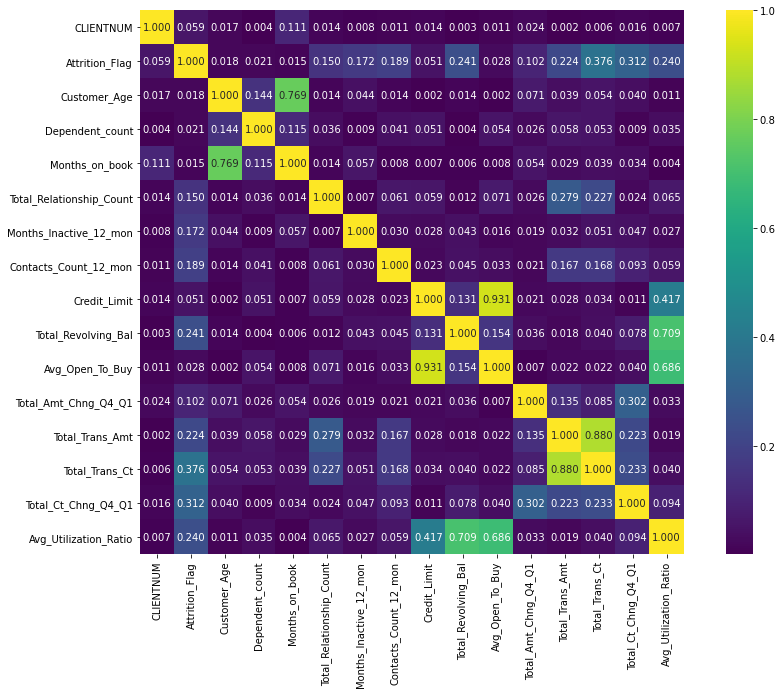

In [301]:
corr_data = df_corr.loc[:, col_num_cor].corr(method='spearman')

plt.figure(figsize=(15,10))
sns.heatmap(corr_data.abs(), annot=True, fmt='.3f',cmap='viridis',square=True)
plt.show()

Pada numeric data, ada beberapa feature yang terdapat korelasi positif lebih besar dibandingkan feature lainnya terhadap Attrition Flag, yaitu:
    1. Total_Revolving_Bal
    2. Total_Trans_Amt
    3. Total_Trans_Ct
    4. Total_Ct_Chng_Q4_Q1
    5. Avg_Utilization_Ratio

In [324]:
df[df['Total_Revolving_Bal']<750][df['Attrition_Flag']==1]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
21,1,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000
39,1,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077
54,1,56,M,2,Graduate,Married,$120K +,Blue,36,1,3,3,15769.0,0,15769.0,1.041,602,15,0.364,0.000
61,1,48,M,2,Graduate,Married,$60K - $80K,Silver,35,2,4,4,34516.0,0,34516.0,0.763,691,15,0.500,0.000
82,1,55,F,4,Unknown,Married,$40K - $60K,Blue,45,2,4,3,2158.0,0,2158.0,0.585,615,12,0.714,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10105,1,59,F,1,High School,Married,Less than $40K,Blue,50,1,4,3,5043.0,743,4300.0,0.805,10170,66,0.784,0.147
10108,1,47,M,4,Graduate,Divorced,$80K - $120K,Blue,39,4,3,4,17504.0,476,17028.0,0.892,10468,66,0.737,0.027
10112,1,33,M,2,College,Married,$120K +,Gold,20,2,1,4,34516.0,0,34516.0,1.004,9338,73,0.622,0.000
10124,1,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


# Summary

### Categorycal Data

1. Pada feature Categorical, Attrition Customer secara signifikan lebih rendah daripada Existing Customer.
2. Angka Attrition tertinggi dari masing-masing feature:
    * Gender:
            - Jumlah pelanggan dengan Attrition tertinggi pada Feature Gender adalah female dengan persentase lebih besar 2,3%. Rasio Gender Female juga lebih besar dibandingkan Existing, dengan nilai 0.17. Angka ini lebih besar dibandingkan Gender Male untuk Attrition dengan nilai 0.14. Namun angka ini tidak 
    * Education Level:
            - Jumlah pelanggan dengan Attrition tertinggi pada Feature Education Level adalah Graduate dengan persentase 4.81%. Untuk Education Level, rasio pelanggan yang Attrition kurang lebih sama dari tingkat High School hingga Collage. Dan, perlahan-lahan terjadi penaikan rasio dari tingkat pascasarjana ke doktoral.
            - Peningkatan rasio ini dikarenakan jumlahnya makin sedikit ketika Educational Levelnya meningkat, jadi tidak bisa dikatakan rasio yang tinggi memiliki kecenderungan untuk Attrition lebih besar, perlu dilihat juga dari aspek lainnya.

    * Marital Status
            - Jumlah pelanggan dengan Attrition tertinggi pada Feature Marital Status adalah Married dengan persentase 7% dan Single sebesar 6.6%. Rasio pada Single 0.16, Divorce dan Unknown sebesar 0.17. Angka rasio pada Single, Divorce, dan Unknown lebih besar dibandingkan dengan Married dengan nilai 0.15.
            - Jadi, kategori Single lebih besar chance untuk Attrition, dikarenakan rasio yang lebih besar dibandingkan dengan Married dan dengan jumlah yang tidak jauh berbeda dibandingkan Married.
            - Kecenderungan untuk Attrition pada Marital Status Single bisa dipicu dikarenakan belum memiliki jumlah tanggungan yang lebih banyak dibandingkan yang Married dan Divorced.

    * Income Category
            - Jumlah pelanggan dengan Attrition tertinggi pada Feature Income Category adalah Less than 40k dengan persentase 6.04%. Semakin tinggi Income Categorynya, semakin turun jumlah pelanggannya.
            - Rasio Attrition terendah pada Income Category 60k-80k dengan nilai 0.18 dibandingkan dengan kategori lainnya.
            - Rasio Income Category 120k+ sama dengan Less than 40k dengan nilai 0.17, rasio ini tertinggi dibandingkan dengan kategori lainnya. Rasio pada 120k+ tinggi karena tingkat penghasilan paling tinggi dan jumlahnya paling sedikit, oleh karena itu rasio attritionnya tinggi walaupun jumlah pelanggan yang attrition berbeda 4.8% dibandingkan Less than 40k.
        
    * Card Category
            - Jumlah pelanggan dengan Attrition tertinggi pada feature Card Category adalah Blue, dengan persentase sangat besar yaitu 15%, angka ini mendekati total dari Attrition Customer sebesar 16.07%.
            - Bisa dikatakan juga mayoritas Attrition Customer pada Card Category Blue.


## Numeric Data

1. Total Revolving Balance
    - Selisih antara Credit Limit dengan Average Open to Buy. Artinya sisa hutang dari peminjaman yang belum terbayarkan tiap bulannya, dalam 12 bulan dengan rata-rata perbulannya kurang dari 750 lebih cenderung untuk Attrition.
    - Hipotesa saya, para pengguna yang Revolving Balance kecil tiap bulannya tidak memiliki kecenderungan menggunakan sesuai dengan porsinya. Pengguna dengan tingkat pendapatannya sesuai dengan kebutuhannya sehari-hari. Jadi, pengguna dengan pendapatan yang stabil seperti ini merasa dirugikan dengan penggunaan kartu kredit yang ada bunganya, sehingga mereka cenderung untuk berhenti atau pindah ke bank lain dengan bunga yang lebih rendah.

2. Total Transaction Amount
    - Attrition Customer tinggi pada jumlah transaksi kurang dari 2500 dolar tiap customer rata-rata dalam 12 bulan terakhir. Customer ini merasa jarang menggunakan kartu kredit yang membuat mereka cenderung berhenti.

3. Total_Trans_Ct
    - Attrition Customer tinggi pada jumlah transaksi kurang dari 50 kali tiap customer dalam 12 bulan terakhir. Customer ini merasa jarang menggunakan kartu kredit yang membuat mereka cenderung berhenti.
    
4. Change in Transaction Count (Q4 over Q1)
    - Change in Transaction Count merupakan rasio kenaikan penggunaan jumlah kartu kredit perbandingan tiap quarternya, Customer Attrition tertinggi dengan nilai kurang dari 0,5. Hal ini berarti menandakan tidak ada perubahan jumlah penggunaan kartu kredit tidak quarternya.

5. Average Utilization Ratio
    - Feature ini menjelaskan rasio seberapa berguna pemanfaatan kartu kredit bagi customernya. Rasio yang Attrition tertinggi adalah pada kurang dari 0.05. Dapat dilhat berarti penggunaan yang rendah dari customer dapat memicu Attrition.

# General Summary and What Solution that I can Help

Dari analisa yang saya lakukan, dapat disimpulkan bahwa mayoritas pengguna dan mayoritas Attrition pada:
1.	Tingkat pendidikan dari SMA sampai S1.
2.	Marital Status menikah dan Single.
3.	Income Catogry Less Than 40 dolar.
4.	Card Category Blue.
5.	Usia tertinggi dari range 37 sampai 59 tahun.
6.	Jumlah tanggungan 2 dan 3.
7.	Penggunaan kartu tertinggi selama 36 bulan.
8.	Customer tertinggi menggunakan produk berjumlah 3.
9.	Customer tidak aktif menggunakan kartu paling lama 3 bulan.
10.	Dan kurangnya rasio penggunaan kartu dalam kegiatan sehari-hari.

Dari permasalahan yang ada, dapat kita ambil solusinya untuk menekan angka Attrion Customer:
1.	Perluas penggunaan kartu kredit khususnya untuk kartu Category Blue dari berbagai sector lebih luas lagi, market place, berbagai merchant, property, kesehatan, pendidikan, transportasi dan lain-lain. Buat promosi yang dapat menimbulkan ketertarikan untuk menggunakan kartu kredit. Dengan cara seperti ini otomatis rasio penggunaan kartu kredit dan membuat customer berpikir kembali bila berhenti menggunakannya.

2.	Buat persyaratan apabila kartu tidak digunakan sama sekali dalam 2 bulan, akan dikenakan biaya administrasi.

3.	Buat persyaratan kembali apabila sudah berlangganan kartu kredit dan apabila nanti berhenti, maka promo-promo yang didapat pelanggan lama tidak akan berlaku kembali ketika mendaftar kembali.


# Pre Processing

First we drop Clientnum.

In [10]:
df = data.copy()

In [11]:
df.drop(data.columns[0], axis = 1, inplace = True)

### Cek Outliers

In [12]:
def boxp(column):
    plt.boxplot(data = data, x = data['Customer_Age'])

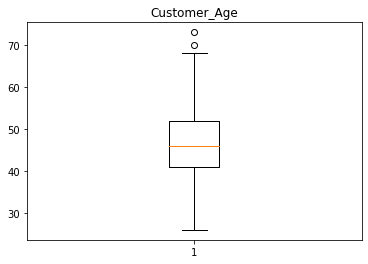

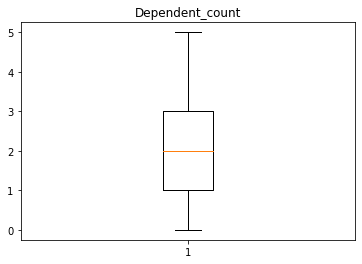

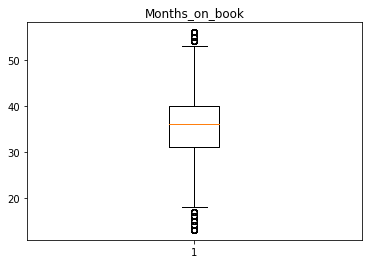

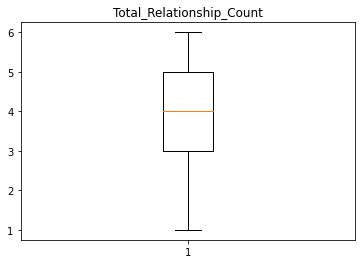

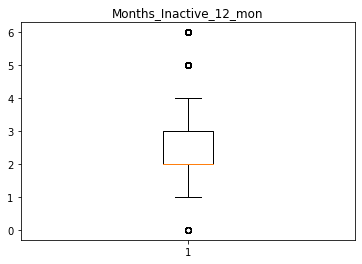

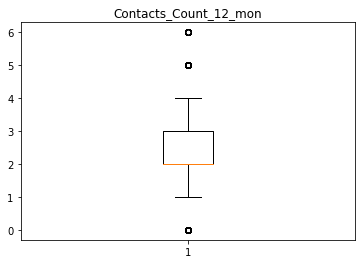

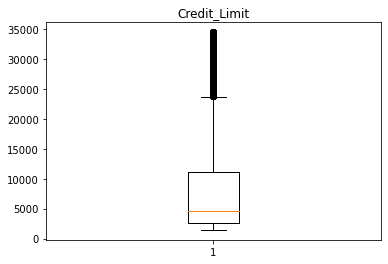

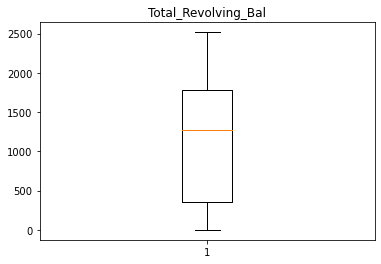

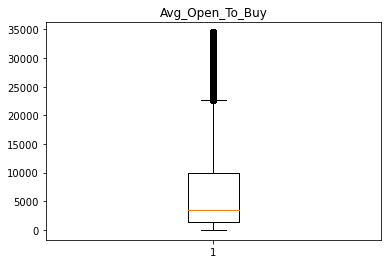

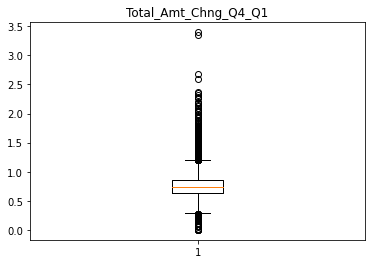

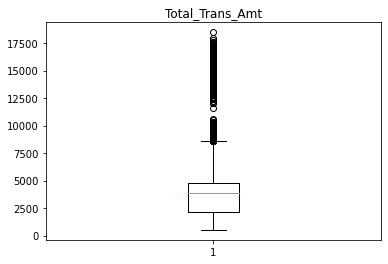

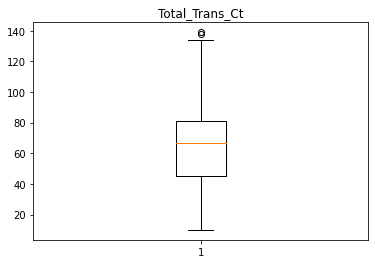

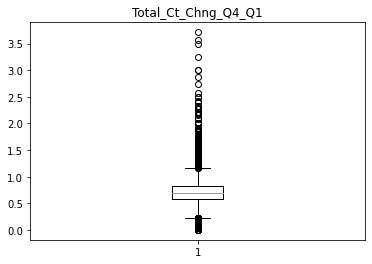

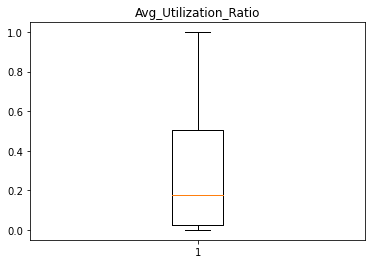

In [13]:
def plot_box(column):
    plt.boxplot(df_all[column])
    plt.title(column)
    plt.show()

for i in col_num:
    plot_box(i)

Terdapatoutliers pada feature:
    1. Credit_Limit
    2. Avg_Open_To_Buy
    3. Total_Amt_Chng_Q4_Q1
    4. Total_Trans_Amt
    5. Total_Ct_Chng_Q4_Q1
    6. Customer_Age
    7. Months_Inactive_12_mon
    8. Contacts_Count_12_mon
    9. Total_Trans_Ct

Preprocessing Scheme
- OneHot: Gender, Education_Level, Marital_Status, Income_Category, Card_Category
- Min Max Scaller: Customer_Age, Credit_Limit, Avg_Open_To_Buy, Total_Amt_Chng_Q4_Q1, Total_Trans_Amt, Total_Ct_Chng_Q4_Q1, Months_Inactive_12_mon, Contacts_Count_12_mon.
- Passthrogh: Dependent_count, Months_on_book, Total_Relationship_Count, Total_Revolving_Bal, Total_Trans_Ct, Total_Trans_Ct, Avg_Utilization_Ratio

In [14]:
df['Attrition_Flag'].value_counts()/data.shape[0]*100

Existing Customer    83.934038
Attrited Customer    16.065962
Name: Attrition_Flag, dtype: float64

Indicated Imbalance Data

* Attrited Customers = 1
* Existing Customers = 0

* *0 = Stay*
* *1 = Drop off*

        - TN: Ada pelanggan yang diprediksi dengan Keep Use dan kenyataannya Off
        - TP: Ada pelanggan yang diprediksi dengan Off dan kenyataannya Off Off
        - FP: Ada pelanggan yang diprediksi dengan Off, padahal Keep Use
        - FN: Ada pelanggan yang diprediksi dengan Keep Use padahal Off

Tindakan:
* FP: Salah prediksi, tidak berpengaruh apa apa
* FN: Perusahaan rugi karena kehilangan pelanggan

- > Yang akan di tekan adalah FN, recall

In [15]:
df['Attrition_Flag'] = np.where(df['Attrition_Flag'] == 'Attrited Customer', 1, 0)

In [16]:
transformer= ColumnTransformer([
    ('one_hot',OneHotEncoder(drop='first'),['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']),
    ('scale',MinMaxScaler(), ['Credit_Limit', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Ct_Chng_Q4_Q1', 'Customer_Age', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon','Total_Trans_Ct'])]
    , remainder='passthrough')

## Splitting Data

In [17]:
X=df.drop('Attrition_Flag',axis=1)
y=df['Attrition_Flag']

In [18]:
X.shape

(10127, 19)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   stratify = y,
                                                   test_size = 0.3,
                                                   random_state = 2020)

## Modelling

*Define Model*
- I use 4 models to predict:
    * Logistic Regression
    * Decision Tree Classifier
    * K-Nearest Neighbor
    * Random Forest

In [20]:
logreg = LogisticRegression(solver='liblinear')
tree = DecisionTreeClassifier(random_state = 1010)
knn = KNeighborsClassifier(n_neighbors = 2)
rf = RandomForestClassifier(random_state = 1010)

## Cross Validation

In [21]:
logreg_pipe = Pipeline([('transformer', transformer), ('logreg', logreg)])
tree_pipe = Pipeline([('transformer', transformer), ('tree', tree)])
knn_pipe = Pipeline([('transformer', transformer), ('knn', knn)])
rf_pipe = Pipeline([('transformer', transformer), ('rf', rf)])

def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

logreg_pipe_cv = model_evaluation(logreg_pipe, 'recall')
tree_pipe_cv = model_evaluation(tree_pipe, 'recall')
knn_pipe_cv = model_evaluation(knn_pipe, 'recall')
rf_pipe_cv = model_evaluation(rf_pipe, 'recall')

for model in [logreg_pipe, tree_pipe, knn_pipe, rf_pipe]:
    model.fit(X_train, y_train)
    
score_mean = [logreg_pipe_cv.mean(), tree_pipe_cv.mean(), knn_pipe_cv.mean(), rf_pipe_cv.mean()]
score_std = [logreg_pipe_cv.std(), tree_pipe_cv.std(), knn_pipe_cv.std(), rf_pipe_cv.std()]
score_recall_score = [recall_score(y_test, logreg_pipe.predict(X_test)),
            recall_score(y_test, tree_pipe.predict(X_test)), 
            recall_score(y_test, knn_pipe.predict(X_test)), 
            recall_score(y_test, rf_pipe.predict(X_test))]
method_name = ['Logistic Regression', 'Decision Tree Classifier', 'KNN Classifier', 'Random Forest Classifier']
cv_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'recall score': score_recall_score
})
cv_summary

,method,mean score,std score,recall score
0,Logistic Regression,0.493465,0.036344,0.514344
1,Decision Tree Classifier,0.781436,0.034123,0.805328
2,KNN Classifier,0.192279,0.031094,0.206967
3,Random Forest Classifier,0.759456,0.025778,0.782787


dari metode ini, kita mendapat nilai recall tertinggi pada Decision Tree Classifier dan Random Forest Classifier. Karna data imbalance, sekarang kita coba handling dengan Under Sampling dan Over Sampling.

# Handling Imbalance

### Random Over Sampling

In [22]:
ros = RandomOverSampler(random_state = 1010)
X_over, y_over = ros.fit_resample(X_train, y_train) 

logreg_pipe_over = Pipeline([('transformer', transformer), ('ros', ros), ('logreg', logreg)])
tree_pipe_over = Pipeline([('transformer', transformer), ('ros', ros), ('tree', tree)])
knn_pipe_over = Pipeline([('transformer', transformer), ('ros', ros), ('knn', knn)])
rf_pipe_over = Pipeline([('transformer', transformer), ('ros', ros), ('rf', rf)])

def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

logreg_over_cv = model_evaluation(logreg_pipe_over, 'recall') 
tree_over_cv = model_evaluation(tree_pipe_over, 'recall')
knn_over_cv = model_evaluation(knn_pipe_over, 'recall')
rf_over_cv = model_evaluation(rf_pipe_over, 'recall')

for model in [logreg_pipe_over, tree_pipe_over, knn_pipe_over, rf_pipe_over]:
    model.fit(X_train, y_train)
    
score_mean = [logreg_over_cv.mean(), tree_over_cv.mean(), knn_over_cv.mean(),
              rf_over_cv.mean()]
score_std = [logreg_over_cv.std(), tree_over_cv.std(), knn_over_cv.std(),
             rf_over_cv.std()]
score_recall_score = [recall_score(y_test, logreg_pipe_over.predict(X_test)),
            recall_score(y_test, tree_pipe_over.predict(X_test)), 
            recall_score(y_test, knn_pipe_over.predict(X_test)), 
            recall_score(y_test, rf_pipe_over.predict(X_test))]
method_name = ['Logistic Regression OverSampling', 'Decision Tree Classifier OverSampling',
              'KNN Classifier OverSampling', 'Random Forest Classifier OverSampling']
over_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'recall score': score_recall_score
})
over_summary

,method,mean score,std score,recall score
0,Logistic Regression OverSampling,0.841070,0.020810,0.840164
1,Decision Tree Classifier OverSampling,0.776126,0.020495,0.750000
2,KNN Classifier OverSampling,0.367872,0.043233,0.368852
3,Random Forest Classifier OverSampling,0.818294,0.022085,0.834016


### Random Under Sampling

In [23]:
rus = RandomUnderSampler(random_state = 1010)
X_under, y_under = rus.fit_resample(X_train, y_train) 

logreg_pipe_under = Pipeline([('transformer', transformer), ('rus', rus), ('logreg', logreg)])
tree_pipe_under = Pipeline([('transformer', transformer), ('rus', rus), ('tree', tree)])
knn_pipe_under = Pipeline([('transformer', transformer), ('rus', rus), ('knn', knn)])
rf_pipe_under = Pipeline([('transformer', transformer), ('rus', rus), ('rf', rf)])

def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

logreg_under_cv = model_evaluation(logreg_pipe_under, 'recall') 
tree_under_cv = model_evaluation(tree_pipe_under, 'recall')
knn_under_cv = model_evaluation(knn_pipe_under, 'recall')
rf_under_cv = model_evaluation(rf_pipe_under, 'recall')

for model in [logreg_pipe_under, tree_pipe_under, knn_pipe_under, rf_pipe_under]:
    model.fit(X_train, y_train)
    
score_mean = [logreg_under_cv.mean(), tree_under_cv.mean(), knn_under_cv.mean(),
              rf_under_cv.mean()]
score_std = [logreg_under_cv.std(), tree_under_cv.std(), knn_under_cv.std(),
             rf_under_cv.std()]
score_recall_score = [recall_score(y_test, logreg_pipe_under.predict(X_test)),
            recall_score(y_test, tree_pipe_under.predict(X_test)), 
            recall_score(y_test, knn_pipe_under.predict(X_test)), 
            recall_score(y_test, rf_pipe_under.predict(X_test))]
method_name = ['Logistic Regression UnderSampling', 'Decision Tree Classifier UnderSampling',
              'KNN Classifier UnderSampling', 'Random Forest Classifier UnderSampling']
under_summary = pd.DataFrame({
    'method': method_name,
    'mean score': score_mean,
    'std score': score_std,
    'recall score': score_recall_score
})
under_summary

,method,mean score,std score,recall score
0,Logistic Regression UnderSampling,0.828770,0.023609,0.834016
1,Decision Tree Classifier UnderSampling,0.886765,0.014910,0.891393
2,KNN Classifier UnderSampling,0.503091,0.046995,0.520492
3,Random Forest Classifier UnderSampling,0.941186,0.008080,0.942623


## Hyper Paramether Tunning

In [24]:
estimator = Pipeline([
    ('transformer', transformer),
    ('balancing', rus),
    ('model', rf)
])

hyperparam_space={
    'model__max_depth':[2,5,7,10],
    'model__min_samples_leaf':[1,5,10,20,50,100],
    'model__min_samples_split':[1,5,10,20,50,100],
    'model__criterion':['gini','entropy']
}


skfold=StratifiedKFold(n_splits=5)

grid_search=GridSearchCV(
    estimator,
    param_grid=hyperparam_space,
    cv=skfold,
    scoring='recall',
    n_jobs=-1
)

In [25]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Gender',
                                                                          'Education_Level',
                                                                          'Marital_Status',
                                                                          'Income_Category',
                                                                          'Card_Category']),
                                                                        ('scale',
                                                            

In [26]:
estimator.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'balancing', 'model', 'transformer__n_jobs', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__one_hot', 'transformer__scale', 'transformer__one_hot__categories', 'transformer__one_hot__drop', 'transformer__one_hot__dtype', 'transformer__one_hot__handle_unknown', 'transformer__one_hot__sparse', 'transformer__scale__clip', 'transformer__scale__copy', 'transformer__scale__feature_range', 'balancing__random_state', 'balancing__replacement', 'balancing__sampling_strategy', 'model__bootstrap', 'model__ccp_alpha', 'model__class_weight', 'model__criterion', 'model__max_depth', 'model__max_features', 'model__max_leaf_nodes', 'model__max_samples', 'model__min_impurity_decrease', 'model__min_impurity_split', 'model__min_samples_leaf', 'model__min_samples_split', 'model__min_weight_fraction_leaf', 'model__n_estimators', 'model__n_j

In [27]:
print('best score', grid_search.best_score_)
print('best param', grid_search.best_params_)

best score 0.9429438132776877
best param {'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 10}


In [30]:
grid_search.best_estimator_.fit(X_train, y_train)
y_predict = grid_search.best_estimator_.predict(X_test)
recall_score(y_test, y_predict)

0.944672131147541

# Saving Model with Pickle

In [32]:
grid_search.best_estimator_.fit(X, y)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Gender', 'Education_Level',
                                                   'Marital_Status',
                                                   'Income_Category',
                                                   'Card_Category']),
                                                 ('scale', MinMaxScaler(),
                                                  ['Credit_Limit',
                                                   'Avg_Open_To_Buy',
                                                   'Total_Amt_Chng_Q4_Q1',
                                                   'Total_Trans_Amt',
                                                   'Total_Ct_Chng_Q4_Q1',
                                                

In [33]:
file_name = 'Attrition_Bank.sav'

pickle.dump(grid_search.best_estimator_, open(file_name,'wb'))

In [34]:
loaded_model = pickle.load(open(file_name,'rb'))
loaded_model.predict(X_test)

array([0, 0, 0, ..., 0, 1, 0])

In [35]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3039 entries, 9989 to 8528
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              3039 non-null   int64  
 1   Gender                    3039 non-null   object 
 2   Dependent_count           3039 non-null   int64  
 3   Education_Level           3039 non-null   object 
 4   Marital_Status            3039 non-null   object 
 5   Income_Category           3039 non-null   object 
 6   Card_Category             3039 non-null   object 
 7   Months_on_book            3039 non-null   int64  
 8   Total_Relationship_Count  3039 non-null   int64  
 9   Months_Inactive_12_mon    3039 non-null   int64  
 10  Contacts_Count_12_mon     3039 non-null   int64  
 11  Credit_Limit              3039 non-null   float64
 12  Total_Revolving_Bal       3039 non-null   int64  
 13  Avg_Open_To_Buy           3039 non-null   float64
 14  Total

# Predict

In [256]:
att_pred = pd.DataFrame({
    'Customer_Age': [48],
    'Gender': ['M'],
    'Dependent_count': [2],
    'Education_Level': ['Graduate'],
    'Marital_Status': ['Married'],
    'Income_Category': ['$60K - $80K'],
    'Card_Category': ['Silver'],
    'Months_on_book': [35],
    'Total_Relationship_Count': [2],
    'Months_Inactive_12_mon': [4],
    'Contacts_Count_12_mon': [4],
    'Credit_Limit':[34516],
    'Total_Revolving_Bal':[0],
    'Avg_Open_To_Buy': [34516],
    'Total_Amt_Chng_Q4_Q1': [0.763],
    'Total_Trans_Amt':[691],
    'Total_Trans_Ct': [15],
    'Total_Ct_Chng_Q4_Q1': [0.5],
    'Avg_Utilization_Ratio': [0.0]
})

In [323]:
df[df['Total_Revolving_Bal']<750][df['Attrition_Flag']==1]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
21,1,62,F,0,Graduate,Married,Less than $40K,Blue,49,2,3,3,1438.3,0,1438.3,1.047,692,16,0.600,0.000
39,1,66,F,0,Doctorate,Married,Unknown,Blue,56,5,4,3,7882.0,605,7277.0,1.052,704,16,0.143,0.077
54,1,56,M,2,Graduate,Married,$120K +,Blue,36,1,3,3,15769.0,0,15769.0,1.041,602,15,0.364,0.000
61,1,48,M,2,Graduate,Married,$60K - $80K,Silver,35,2,4,4,34516.0,0,34516.0,0.763,691,15,0.500,0.000
82,1,55,F,4,Unknown,Married,$40K - $60K,Blue,45,2,4,3,2158.0,0,2158.0,0.585,615,12,0.714,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10105,1,59,F,1,High School,Married,Less than $40K,Blue,50,1,4,3,5043.0,743,4300.0,0.805,10170,66,0.784,0.147
10108,1,47,M,4,Graduate,Divorced,$80K - $120K,Blue,39,4,3,4,17504.0,476,17028.0,0.892,10468,66,0.737,0.027
10112,1,33,M,2,College,Married,$120K +,Gold,20,2,1,4,34516.0,0,34516.0,1.004,9338,73,0.622,0.000
10124,1,44,F,1,High School,Married,Less than $40K,Blue,36,5,3,4,5409.0,0,5409.0,0.819,10291,60,0.818,0.000


In [321]:
df[df['Total_Revolving_Bal']<600][df['Income_Category']]

TypeError: 'DataFrame' object is not callable

In [234]:
df.Income_Category.unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [257]:
att_pred

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,48,M,2,Graduate,Married,$60K - $80K,Silver,35,2,4,4,34516,0,34516,0.763,691,15,0.5,0.0


In [263]:
loaded_model.predict(att_pred)

array([1])

In [264]:
loaded_model.predict_proba(att_pred)

array([[0.05291321, 0.94708679]])